# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-mc-kfold'
epochs = 10
batch_size = 64
sequence_length = 80
min_increment = 200

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [10]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [11]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [12]:
data['Tweet'] = data['Tweet'].apply(preprocess)
label_columns = data.columns[1:]

# BUILD DATASET & DATALOADERS

In [13]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [14]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [15]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def train_model(current_train_size, train_indices, metrics, trials, seed, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(f"Fold {trials + 1} - Training with {current_train_size} samples")

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders using the fold's data
    current_X_train = [X_train_fold[i] for i in train_indices]
    current_y_train = [y_train_fold[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val_fold, y_val_fold)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-fold-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result
        
        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Best result for {current_train_size} samples: F1 Micro: {round(best_result['f1_micro'], 4)}")
    accelerator.print(best_result['report'])
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [17]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [18]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, X_train_fold, y_train_fold, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in most_uncertain_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train_fold[i] for i in temp],
                'HS': [y_train_fold[i][0] for i in temp],
                'Abusive': [y_train_fold[i][1] for i in temp],
                'HS_Individual': [y_train_fold[i][2] for i in temp],
                'HS_Group': [y_train_fold[i][3] for i in temp],
                'HS_Religion': [y_train_fold[i][4] for i in temp],
                'HS_Race': [y_train_fold[i][5] for i in temp],
                'HS_Physical': [y_train_fold[i][6] for i in temp],
                'HS_Gender': [y_train_fold[i][7] for i in temp],
                'HS_Other': [y_train_fold[i][8] for i in temp],
                'HS_Weak': [y_train_fold[i][9] for i in temp],
                'HS_Moderate': [y_train_fold[i][10] for i in temp],
                'HS_Strong': [y_train_fold[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [19]:
from sklearn.model_selection import KFold

N_SPLITS = 5
RANDOM_SEED = 42

# Prepare data for K-Fold
label_columns = data.columns[1:]
X = data['Tweet'].values
y = data[label_columns].values
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

all_fold_accuracies = []
all_fold_f1_micros = []
all_fold_f1_macros = []
all_fold_data_used = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print("===============================================")
    print(f"STARTING FOLD {fold + 1}/{N_SPLITS}")
    print("===============================================")

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    train_fold_df = pd.DataFrame(X_train_fold, columns=['Tweet'])
    train_fold_df[label_columns] = y_train_fold

    val_fold_df = pd.DataFrame(X_val_fold, columns=['Tweet'])
    val_fold_df[label_columns] = y_val_fold

    fold_data_dir = 'kfold_splits'
    if not os.path.exists(fold_data_dir):
        os.makedirs(fold_data_dir)

    train_fold_df.to_csv(f'{fold_data_dir}/train_fold_{fold + 1}.csv', index=False)
    val_fold_df.to_csv(f'{fold_data_dir}/val_fold_{fold + 1}.csv', index=False)

    # Shared resources for this fold's processes
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    
    set_seed(RANDOM_SEED + fold)
    
    # Define the initial labeled pool from the current fold's training data
    total_train_fold_size = len(X_train_fold) + len(X_val_fold)
    initial_train_size = int(0.05 * total_train_fold_size)
    
    train_indices = np.random.choice(range(len(X_train_fold)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train_fold))) - set(train_indices))
    current_train_size = initial_train_size

    checkpoints = [
        int(0.5 * total_train_fold_size), 
        int(0.6 * total_train_fold_size),
        int(0.7 * total_train_fold_size),
        len(X_train_fold)
    ]
    
    fold_start_time = time.time()
    
    while current_train_size < total_train_fold_size:
        # Train the model on the current labeled set
        train_args = (
            current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros),
            fold, RANDOM_SEED + fold, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns
        )
        notebook_launcher(train_model, train_args, num_processes=2)
        
        # Stop if we've reached the last checkpoint
        if current_train_size >= checkpoints[-1]:
            break

        model = BertForSequenceClassification.from_pretrained(f'{filename}-fold-{fold + 1}-model')
        
        # Perform query strategy to select new samples
        new_samples_shared = manager.list()
        X_pool = [X_train_fold[i] for i in remaining_indices]
        sampling_args = (
            model, X_pool, train_indices, remaining_indices, sampling_dur, 
            new_samples_shared, fold, X_train_fold, y_train_fold
        )
        notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        
        # Update the pools
        newly_acquired_indices = list(new_samples_shared)
        train_indices.extend(newly_acquired_indices)
        remaining_indices = list(set(remaining_indices) - set(newly_acquired_indices))
    
        current_train_size = len(train_indices)
        print(f"\nFold {fold + 1} - New train size: {current_train_size}\n")
    
    fold_end_time = time.time()
    print(f"\nFOLD {fold + 1} COMPLETED in {fold_end_time - fold_start_time:.2f} seconds")
    
    # Store the results for this fold
    all_fold_data_used.append(list(data_used))
    all_fold_accuracies.append(list(accuracies))
    all_fold_f1_micros.append(list(f1_micros))
    all_fold_f1_macros.append(list(f1_macros))

STARTING FOLD 1/5
Launching training on 2 GPUs.
Fold 1 - Training with 658 samples


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.6398, Accuracy: 0.7977, F1 Micro: 0.3894, F1 Macro: 0.1173
Epoch 2/10, Train Loss: 0.4791, Accuracy: 0.8349, F1 Micro: 0.1631, F1 Macro: 0.0493
Epoch 3/10, Train Loss: 0.4083, Accuracy: 0.8329, F1 Micro: 0.1055, F1 Macro: 0.0371
Epoch 4/10, Train Loss: 0.3819, Accuracy: 0.8329, F1 Micro: 0.0977, F1 Macro: 0.0354
Epoch 5/10, Train Loss: 0.3775, Accuracy: 0.8368, F1 Micro: 0.1577, F1 Macro: 0.0517
Epoch 6/10, Train Loss: 0.3646, Accuracy: 0.8432, F1 Micro: 0.2313, F1 Macro: 0.0778
Epoch 7/10, Train Loss: 0.3564, Accuracy: 0.8514, F1 Micro: 0.3095, F1 Macro: 0.1032
Epoch 8/10, Train Loss: 0.3305, Accuracy: 0.861, F1 Micro: 0.3998, F1 Macro: 0.1449
Epoch 9/10, Train Loss: 0.3159, Accuracy: 0.8714, F1 Micro: 0.4936, F1 Macro: 0.2158
Epoch 10/10, Train Loss: 0.2956, Accuracy: 0.8752, F1 Micro: 0.5329, F1 Macro: 0.2447
Best result for 658 samples: F1 Micro: 0.5329
               precision    recall  f1-score   support

           HS       0.83      0.62      0.71    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5681, Accuracy: 0.8133, F1 Micro: 0.4068, F1 Macro: 0.1045
Epoch 2/10, Train Loss: 0.4459, Accuracy: 0.8305, F1 Micro: 0.3974, F1 Macro: 0.1085
Epoch 3/10, Train Loss: 0.414, Accuracy: 0.8459, F1 Micro: 0.4143, F1 Macro: 0.1236
Epoch 4/10, Train Loss: 0.3952, Accuracy: 0.8635, F1 Micro: 0.5191, F1 Macro: 0.2379
Epoch 5/10, Train Loss: 0.362, Accuracy: 0.8846, F1 Micro: 0.6156, F1 Macro: 0.347
Epoch 6/10, Train Loss: 0.3214, Accuracy: 0.8947, F1 Micro: 0.6508, F1 Macro: 0.3995
Epoch 7/10, Train Loss: 0.2899, Accuracy: 0.8984, F1 Micro: 0.6812, F1 Macro: 0.442
Epoch 8/10, Train Loss: 0.2547, Accuracy: 0.9022, F1 Micro: 0.6833, F1 Macro: 0.4618
Epoch 9/10, Train Loss: 0.2332, Accuracy: 0.9042, F1 Micro: 0.6865, F1 Macro: 0.4929
Epoch 10/10, Train Loss: 0.208, Accuracy: 0.9041, F1 Micro: 0.7137, F1 Macro: 0.5303
Best result for 1646 samples: F1 Micro: 0.7137
               precision    recall  f1-score   support

           HS       0.82      0.82      0.82      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5278, Accuracy: 0.8232, F1 Micro: 0.3681, F1 Macro: 0.0994
Epoch 2/10, Train Loss: 0.43, Accuracy: 0.8374, F1 Micro: 0.3831, F1 Macro: 0.1126
Epoch 3/10, Train Loss: 0.3981, Accuracy: 0.8585, F1 Micro: 0.4999, F1 Macro: 0.2242
Epoch 4/10, Train Loss: 0.3684, Accuracy: 0.893, F1 Micro: 0.6549, F1 Macro: 0.4103
Epoch 5/10, Train Loss: 0.3188, Accuracy: 0.9017, F1 Micro: 0.7042, F1 Macro: 0.4974
Epoch 6/10, Train Loss: 0.2871, Accuracy: 0.907, F1 Micro: 0.7038, F1 Macro: 0.5022
Epoch 7/10, Train Loss: 0.2417, Accuracy: 0.908, F1 Micro: 0.7307, F1 Macro: 0.551
Epoch 8/10, Train Loss: 0.2121, Accuracy: 0.9119, F1 Micro: 0.7326, F1 Macro: 0.5598
Epoch 9/10, Train Loss: 0.1826, Accuracy: 0.9129, F1 Micro: 0.7263, F1 Macro: 0.5596
Epoch 10/10, Train Loss: 0.1641, Accuracy: 0.9136, F1 Micro: 0.7224, F1 Macro: 0.5503
Best result for 2535 samples: F1 Micro: 0.7326
               precision    recall  f1-score   support

           HS       0.85      0.82      0.83      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5063, Accuracy: 0.8243, F1 Micro: 0.3909, F1 Macro: 0.1055
Epoch 2/10, Train Loss: 0.4214, Accuracy: 0.8422, F1 Micro: 0.4313, F1 Macro: 0.1725
Epoch 3/10, Train Loss: 0.3845, Accuracy: 0.8821, F1 Micro: 0.6236, F1 Macro: 0.3529
Epoch 4/10, Train Loss: 0.3405, Accuracy: 0.9017, F1 Micro: 0.7179, F1 Macro: 0.5275
Epoch 5/10, Train Loss: 0.2978, Accuracy: 0.9097, F1 Micro: 0.7019, F1 Macro: 0.5324
Epoch 6/10, Train Loss: 0.2624, Accuracy: 0.9104, F1 Micro: 0.746, F1 Macro: 0.5633
Epoch 7/10, Train Loss: 0.2242, Accuracy: 0.9109, F1 Micro: 0.7473, F1 Macro: 0.5669
Epoch 8/10, Train Loss: 0.1884, Accuracy: 0.9179, F1 Micro: 0.7485, F1 Macro: 0.589
Epoch 9/10, Train Loss: 0.1564, Accuracy: 0.9185, F1 Micro: 0.7562, F1 Macro: 0.6002
Epoch 10/10, Train Loss: 0.1383, Accuracy: 0.9163, F1 Micro: 0.7489, F1 Macro: 0.5941
Best result for 3335 samples: F1 Micro: 0.7562
               precision    recall  f1-score   support

           HS       0.87      0.83      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4976, Accuracy: 0.8228, F1 Micro: 0.4018, F1 Macro: 0.1069
Epoch 2/10, Train Loss: 0.4147, Accuracy: 0.8591, F1 Micro: 0.5616, F1 Macro: 0.2829
Epoch 3/10, Train Loss: 0.3724, Accuracy: 0.8928, F1 Micro: 0.6546, F1 Macro: 0.4166
Epoch 4/10, Train Loss: 0.3319, Accuracy: 0.9081, F1 Micro: 0.7173, F1 Macro: 0.5273
Epoch 5/10, Train Loss: 0.2942, Accuracy: 0.915, F1 Micro: 0.7319, F1 Macro: 0.556
Epoch 6/10, Train Loss: 0.2474, Accuracy: 0.9176, F1 Micro: 0.7517, F1 Macro: 0.5913
Epoch 7/10, Train Loss: 0.2113, Accuracy: 0.9169, F1 Micro: 0.7604, F1 Macro: 0.5975
Epoch 8/10, Train Loss: 0.1758, Accuracy: 0.9165, F1 Micro: 0.759, F1 Macro: 0.6001
Epoch 9/10, Train Loss: 0.1581, Accuracy: 0.9187, F1 Micro: 0.7505, F1 Macro: 0.5963
Epoch 10/10, Train Loss: 0.1298, Accuracy: 0.9194, F1 Micro: 0.7605, F1 Macro: 0.6208
Best result for 4055 samples: F1 Micro: 0.7605
               precision    recall  f1-score   support

           HS       0.86      0.84      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4883, Accuracy: 0.8252, F1 Micro: 0.3989, F1 Macro: 0.1079
Epoch 2/10, Train Loss: 0.4047, Accuracy: 0.8631, F1 Micro: 0.5206, F1 Macro: 0.2591
Epoch 3/10, Train Loss: 0.3606, Accuracy: 0.9028, F1 Micro: 0.6937, F1 Macro: 0.5093
Epoch 4/10, Train Loss: 0.3126, Accuracy: 0.9138, F1 Micro: 0.72, F1 Macro: 0.5479
Epoch 5/10, Train Loss: 0.2707, Accuracy: 0.9169, F1 Micro: 0.7355, F1 Macro: 0.58
Epoch 6/10, Train Loss: 0.2356, Accuracy: 0.9191, F1 Micro: 0.7612, F1 Macro: 0.6018
Epoch 7/10, Train Loss: 0.1907, Accuracy: 0.9186, F1 Micro: 0.768, F1 Macro: 0.6095
Epoch 8/10, Train Loss: 0.161, Accuracy: 0.9207, F1 Micro: 0.7566, F1 Macro: 0.6039
Epoch 9/10, Train Loss: 0.1319, Accuracy: 0.9208, F1 Micro: 0.7676, F1 Macro: 0.6146
Epoch 10/10, Train Loss: 0.1159, Accuracy: 0.9187, F1 Micro: 0.7659, F1 Macro: 0.6243
Best result for 4703 samples: F1 Micro: 0.768
               precision    recall  f1-score   support

           HS       0.83      0.89      0.86      114

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.481, Accuracy: 0.8327, F1 Micro: 0.4124, F1 Macro: 0.1238
Epoch 2/10, Train Loss: 0.3918, Accuracy: 0.8885, F1 Micro: 0.6385, F1 Macro: 0.3669
Epoch 3/10, Train Loss: 0.3381, Accuracy: 0.9058, F1 Micro: 0.7041, F1 Macro: 0.5218
Epoch 4/10, Train Loss: 0.2922, Accuracy: 0.9153, F1 Micro: 0.7506, F1 Macro: 0.5688
Epoch 5/10, Train Loss: 0.247, Accuracy: 0.918, F1 Micro: 0.7342, F1 Macro: 0.5791
Epoch 6/10, Train Loss: 0.2109, Accuracy: 0.9187, F1 Micro: 0.7669, F1 Macro: 0.6152
Epoch 7/10, Train Loss: 0.1701, Accuracy: 0.9207, F1 Micro: 0.7683, F1 Macro: 0.615
Epoch 8/10, Train Loss: 0.1463, Accuracy: 0.9242, F1 Micro: 0.7742, F1 Macro: 0.6322
Epoch 9/10, Train Loss: 0.1321, Accuracy: 0.924, F1 Micro: 0.769, F1 Macro: 0.629
Epoch 10/10, Train Loss: 0.1049, Accuracy: 0.9241, F1 Micro: 0.775, F1 Macro: 0.629
Best result for 5287 samples: F1 Micro: 0.775
               precision    recall  f1-score   support

           HS       0.87      0.84      0.86      1141
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4754, Accuracy: 0.8383, F1 Micro: 0.4443, F1 Macro: 0.1625
Epoch 2/10, Train Loss: 0.3881, Accuracy: 0.895, F1 Micro: 0.6555, F1 Macro: 0.4399
Epoch 3/10, Train Loss: 0.3292, Accuracy: 0.9091, F1 Micro: 0.6982, F1 Macro: 0.522
Epoch 4/10, Train Loss: 0.2793, Accuracy: 0.9171, F1 Micro: 0.7589, F1 Macro: 0.585
Epoch 5/10, Train Loss: 0.2404, Accuracy: 0.9211, F1 Micro: 0.7686, F1 Macro: 0.6156
Epoch 6/10, Train Loss: 0.2015, Accuracy: 0.9202, F1 Micro: 0.7699, F1 Macro: 0.6294
Epoch 7/10, Train Loss: 0.1719, Accuracy: 0.9178, F1 Micro: 0.7692, F1 Macro: 0.6356
Epoch 8/10, Train Loss: 0.1439, Accuracy: 0.9247, F1 Micro: 0.7775, F1 Macro: 0.6398
Epoch 9/10, Train Loss: 0.1214, Accuracy: 0.9236, F1 Micro: 0.7752, F1 Macro: 0.6487
Epoch 10/10, Train Loss: 0.106, Accuracy: 0.9249, F1 Micro: 0.7819, F1 Macro: 0.6733
Best result for 5812 samples: F1 Micro: 0.7819
               precision    recall  f1-score   support

           HS       0.84      0.86      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4693, Accuracy: 0.8477, F1 Micro: 0.4658, F1 Macro: 0.192
Epoch 2/10, Train Loss: 0.3711, Accuracy: 0.899, F1 Micro: 0.6735, F1 Macro: 0.4635
Epoch 3/10, Train Loss: 0.316, Accuracy: 0.915, F1 Micro: 0.7313, F1 Macro: 0.5666
Epoch 4/10, Train Loss: 0.265, Accuracy: 0.9213, F1 Micro: 0.7522, F1 Macro: 0.599
Epoch 5/10, Train Loss: 0.2236, Accuracy: 0.9218, F1 Micro: 0.7704, F1 Macro: 0.6258
Epoch 6/10, Train Loss: 0.1903, Accuracy: 0.9257, F1 Micro: 0.7845, F1 Macro: 0.6444
Epoch 7/10, Train Loss: 0.1557, Accuracy: 0.9253, F1 Micro: 0.7807, F1 Macro: 0.6468
Epoch 8/10, Train Loss: 0.1313, Accuracy: 0.9258, F1 Micro: 0.7762, F1 Macro: 0.6578
Epoch 9/10, Train Loss: 0.1147, Accuracy: 0.9258, F1 Micro: 0.779, F1 Macro: 0.6709
Epoch 10/10, Train Loss: 0.0999, Accuracy: 0.9255, F1 Micro: 0.7799, F1 Macro: 0.678
Best result for 6285 samples: F1 Micro: 0.7845
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86      1141

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4648, Accuracy: 0.8518, F1 Micro: 0.4635, F1 Macro: 0.1985
Epoch 2/10, Train Loss: 0.3663, Accuracy: 0.9022, F1 Micro: 0.6898, F1 Macro: 0.4667
Epoch 3/10, Train Loss: 0.3115, Accuracy: 0.9147, F1 Micro: 0.7476, F1 Macro: 0.5814
Epoch 4/10, Train Loss: 0.258, Accuracy: 0.9214, F1 Micro: 0.7604, F1 Macro: 0.5983
Epoch 5/10, Train Loss: 0.2202, Accuracy: 0.9229, F1 Micro: 0.761, F1 Macro: 0.6088
Epoch 6/10, Train Loss: 0.1837, Accuracy: 0.9199, F1 Micro: 0.774, F1 Macro: 0.6263
Epoch 7/10, Train Loss: 0.1554, Accuracy: 0.9261, F1 Micro: 0.7748, F1 Macro: 0.6354
Epoch 8/10, Train Loss: 0.1309, Accuracy: 0.924, F1 Micro: 0.7794, F1 Macro: 0.6493
Epoch 9/10, Train Loss: 0.1146, Accuracy: 0.9267, F1 Micro: 0.7849, F1 Macro: 0.6623
Epoch 10/10, Train Loss: 0.0969, Accuracy: 0.9265, F1 Micro: 0.7838, F1 Macro: 0.6852
Best result for 6584 samples: F1 Micro: 0.7849
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4568, Accuracy: 0.8549, F1 Micro: 0.4905, F1 Macro: 0.2188
Epoch 2/10, Train Loss: 0.3573, Accuracy: 0.8973, F1 Micro: 0.6255, F1 Macro: 0.4079
Epoch 3/10, Train Loss: 0.2959, Accuracy: 0.917, F1 Micro: 0.7384, F1 Macro: 0.5841
Epoch 4/10, Train Loss: 0.2467, Accuracy: 0.9213, F1 Micro: 0.7478, F1 Macro: 0.602
Epoch 5/10, Train Loss: 0.2108, Accuracy: 0.9254, F1 Micro: 0.7769, F1 Macro: 0.6321
Epoch 6/10, Train Loss: 0.1758, Accuracy: 0.9247, F1 Micro: 0.7784, F1 Macro: 0.6611
Epoch 7/10, Train Loss: 0.1519, Accuracy: 0.9255, F1 Micro: 0.7808, F1 Macro: 0.6648
Epoch 8/10, Train Loss: 0.1273, Accuracy: 0.9275, F1 Micro: 0.7857, F1 Macro: 0.6769
Epoch 9/10, Train Loss: 0.1076, Accuracy: 0.9257, F1 Micro: 0.7845, F1 Macro: 0.6962
Epoch 10/10, Train Loss: 0.0959, Accuracy: 0.9227, F1 Micro: 0.7835, F1 Macro: 0.7001
Best result for 6980 samples: F1 Micro: 0.7857
               precision    recall  f1-score   support

           HS       0.87      0.84      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4544, Accuracy: 0.8583, F1 Micro: 0.5122, F1 Macro: 0.223
Epoch 2/10, Train Loss: 0.3467, Accuracy: 0.9043, F1 Micro: 0.7223, F1 Macro: 0.5323
Epoch 3/10, Train Loss: 0.2817, Accuracy: 0.9167, F1 Micro: 0.751, F1 Macro: 0.5686
Epoch 4/10, Train Loss: 0.2453, Accuracy: 0.9228, F1 Micro: 0.7725, F1 Macro: 0.6199
Epoch 5/10, Train Loss: 0.2048, Accuracy: 0.9259, F1 Micro: 0.7825, F1 Macro: 0.6423
Epoch 6/10, Train Loss: 0.1782, Accuracy: 0.9237, F1 Micro: 0.7818, F1 Macro: 0.6373
Epoch 7/10, Train Loss: 0.1445, Accuracy: 0.9257, F1 Micro: 0.7801, F1 Macro: 0.6502
Epoch 8/10, Train Loss: 0.1282, Accuracy: 0.927, F1 Micro: 0.7813, F1 Macro: 0.6548
Epoch 9/10, Train Loss: 0.1132, Accuracy: 0.9232, F1 Micro: 0.7859, F1 Macro: 0.6852
Epoch 10/10, Train Loss: 0.0932, Accuracy: 0.9277, F1 Micro: 0.7839, F1 Macro: 0.7036
Best result for 7336 samples: F1 Micro: 0.7859
               precision    recall  f1-score   support

           HS       0.81      0.91      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4479, Accuracy: 0.8717, F1 Micro: 0.5744, F1 Macro: 0.2869
Epoch 2/10, Train Loss: 0.339, Accuracy: 0.9077, F1 Micro: 0.7163, F1 Macro: 0.5107
Epoch 3/10, Train Loss: 0.2764, Accuracy: 0.9181, F1 Micro: 0.7535, F1 Macro: 0.5874
Epoch 4/10, Train Loss: 0.2368, Accuracy: 0.922, F1 Micro: 0.7709, F1 Macro: 0.614
Epoch 5/10, Train Loss: 0.2005, Accuracy: 0.9227, F1 Micro: 0.7703, F1 Macro: 0.6346
Epoch 6/10, Train Loss: 0.1729, Accuracy: 0.9282, F1 Micro: 0.7802, F1 Macro: 0.6546
Epoch 7/10, Train Loss: 0.1451, Accuracy: 0.9259, F1 Micro: 0.7849, F1 Macro: 0.6636
Epoch 8/10, Train Loss: 0.1219, Accuracy: 0.9266, F1 Micro: 0.7818, F1 Macro: 0.6778
Epoch 9/10, Train Loss: 0.1026, Accuracy: 0.9262, F1 Micro: 0.7844, F1 Macro: 0.6797
Epoch 10/10, Train Loss: 0.0904, Accuracy: 0.9269, F1 Micro: 0.7826, F1 Macro: 0.6983
Best result for 7656 samples: F1 Micro: 0.7849
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4449, Accuracy: 0.8782, F1 Micro: 0.556, F1 Macro: 0.2842
Epoch 2/10, Train Loss: 0.327, Accuracy: 0.9062, F1 Micro: 0.6909, F1 Macro: 0.5184
Epoch 3/10, Train Loss: 0.265, Accuracy: 0.9147, F1 Micro: 0.7139, F1 Macro: 0.5602
Epoch 4/10, Train Loss: 0.2299, Accuracy: 0.9236, F1 Micro: 0.7694, F1 Macro: 0.6175
Epoch 5/10, Train Loss: 0.1906, Accuracy: 0.925, F1 Micro: 0.7769, F1 Macro: 0.6394
Epoch 6/10, Train Loss: 0.1605, Accuracy: 0.9266, F1 Micro: 0.7838, F1 Macro: 0.6649
Epoch 7/10, Train Loss: 0.1404, Accuracy: 0.9258, F1 Micro: 0.7851, F1 Macro: 0.6646
Epoch 8/10, Train Loss: 0.1206, Accuracy: 0.9233, F1 Micro: 0.7851, F1 Macro: 0.6876
Epoch 9/10, Train Loss: 0.1064, Accuracy: 0.9283, F1 Micro: 0.7859, F1 Macro: 0.6974
Epoch 10/10, Train Loss: 0.0878, Accuracy: 0.9252, F1 Micro: 0.7839, F1 Macro: 0.6952
Best result for 7901 samples: F1 Micro: 0.7859
               precision    recall  f1-score   support

           HS       0.87      0.83      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4388, Accuracy: 0.883, F1 Micro: 0.6017, F1 Macro: 0.3041
Epoch 2/10, Train Loss: 0.3165, Accuracy: 0.9105, F1 Micro: 0.7282, F1 Macro: 0.5359
Epoch 3/10, Train Loss: 0.2628, Accuracy: 0.9183, F1 Micro: 0.7461, F1 Macro: 0.5512
Epoch 4/10, Train Loss: 0.218, Accuracy: 0.9225, F1 Micro: 0.7528, F1 Macro: 0.5935
Epoch 5/10, Train Loss: 0.1847, Accuracy: 0.9267, F1 Micro: 0.7802, F1 Macro: 0.6362
Epoch 6/10, Train Loss: 0.1577, Accuracy: 0.9238, F1 Micro: 0.7822, F1 Macro: 0.6411
Epoch 7/10, Train Loss: 0.1331, Accuracy: 0.9265, F1 Micro: 0.7777, F1 Macro: 0.6573
Epoch 8/10, Train Loss: 0.1147, Accuracy: 0.9279, F1 Micro: 0.7882, F1 Macro: 0.6785
Epoch 9/10, Train Loss: 0.1003, Accuracy: 0.9268, F1 Micro: 0.7828, F1 Macro: 0.6946
Epoch 10/10, Train Loss: 0.0855, Accuracy: 0.926, F1 Micro: 0.7865, F1 Macro: 0.7054
Best result for 8165 samples: F1 Micro: 0.7882
               precision    recall  f1-score   support

           HS       0.87      0.87      0.87     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4308, Accuracy: 0.8854, F1 Micro: 0.6447, F1 Macro: 0.3482
Epoch 2/10, Train Loss: 0.3105, Accuracy: 0.9106, F1 Micro: 0.7277, F1 Macro: 0.5276
Epoch 3/10, Train Loss: 0.255, Accuracy: 0.9206, F1 Micro: 0.7547, F1 Macro: 0.5901
Epoch 4/10, Train Loss: 0.2103, Accuracy: 0.9225, F1 Micro: 0.7711, F1 Macro: 0.6209
Epoch 5/10, Train Loss: 0.1834, Accuracy: 0.9267, F1 Micro: 0.7741, F1 Macro: 0.623
Epoch 6/10, Train Loss: 0.1542, Accuracy: 0.9267, F1 Micro: 0.7772, F1 Macro: 0.6593
Epoch 7/10, Train Loss: 0.1294, Accuracy: 0.9257, F1 Micro: 0.7798, F1 Macro: 0.6491
Epoch 8/10, Train Loss: 0.1136, Accuracy: 0.9275, F1 Micro: 0.7817, F1 Macro: 0.6625
Epoch 9/10, Train Loss: 0.0958, Accuracy: 0.9294, F1 Micro: 0.782, F1 Macro: 0.6707
Epoch 10/10, Train Loss: 0.0818, Accuracy: 0.9285, F1 Micro: 0.786, F1 Macro: 0.6995
Best result for 8402 samples: F1 Micro: 0.786
               precision    recall  f1-score   support

           HS       0.88      0.83      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4242, Accuracy: 0.8834, F1 Micro: 0.5715, F1 Macro: 0.2888
Epoch 2/10, Train Loss: 0.3005, Accuracy: 0.911, F1 Micro: 0.7189, F1 Macro: 0.5164
Epoch 3/10, Train Loss: 0.2491, Accuracy: 0.9198, F1 Micro: 0.7503, F1 Macro: 0.5759
Epoch 4/10, Train Loss: 0.2124, Accuracy: 0.9236, F1 Micro: 0.7816, F1 Macro: 0.6256
Epoch 5/10, Train Loss: 0.1774, Accuracy: 0.9237, F1 Micro: 0.7792, F1 Macro: 0.6515
Epoch 6/10, Train Loss: 0.1505, Accuracy: 0.9249, F1 Micro: 0.7841, F1 Macro: 0.6559
Epoch 7/10, Train Loss: 0.1246, Accuracy: 0.9264, F1 Micro: 0.7838, F1 Macro: 0.6726
Epoch 8/10, Train Loss: 0.109, Accuracy: 0.924, F1 Micro: 0.7831, F1 Macro: 0.6842
Epoch 9/10, Train Loss: 0.0927, Accuracy: 0.9262, F1 Micro: 0.7812, F1 Macro: 0.6807
Epoch 10/10, Train Loss: 0.081, Accuracy: 0.9272, F1 Micro: 0.7875, F1 Macro: 0.7036
Best result for 8616 samples: F1 Micro: 0.7875
               precision    recall  f1-score   support

           HS       0.85      0.86      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4224, Accuracy: 0.8871, F1 Micro: 0.6057, F1 Macro: 0.303
Epoch 2/10, Train Loss: 0.2968, Accuracy: 0.9109, F1 Micro: 0.7228, F1 Macro: 0.5481
Epoch 3/10, Train Loss: 0.2434, Accuracy: 0.9202, F1 Micro: 0.764, F1 Macro: 0.6022
Epoch 4/10, Train Loss: 0.2016, Accuracy: 0.9258, F1 Micro: 0.7732, F1 Macro: 0.6194
Epoch 5/10, Train Loss: 0.1749, Accuracy: 0.9231, F1 Micro: 0.7801, F1 Macro: 0.6395
Epoch 6/10, Train Loss: 0.1511, Accuracy: 0.9263, F1 Micro: 0.7796, F1 Macro: 0.6554
Epoch 7/10, Train Loss: 0.1257, Accuracy: 0.9255, F1 Micro: 0.7825, F1 Macro: 0.6665
Epoch 8/10, Train Loss: 0.1061, Accuracy: 0.9267, F1 Micro: 0.7832, F1 Macro: 0.6693
Epoch 9/10, Train Loss: 0.0948, Accuracy: 0.9276, F1 Micro: 0.7832, F1 Macro: 0.6945
Epoch 10/10, Train Loss: 0.0805, Accuracy: 0.9289, F1 Micro: 0.7864, F1 Macro: 0.6975
Best result for 8816 samples: F1 Micro: 0.7864
               precision    recall  f1-score   support

           HS       0.89      0.83      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4214, Accuracy: 0.8879, F1 Micro: 0.6153, F1 Macro: 0.3049
Epoch 2/10, Train Loss: 0.2956, Accuracy: 0.9115, F1 Micro: 0.7195, F1 Macro: 0.5267
Epoch 3/10, Train Loss: 0.2392, Accuracy: 0.9204, F1 Micro: 0.7473, F1 Macro: 0.5901
Epoch 4/10, Train Loss: 0.202, Accuracy: 0.9254, F1 Micro: 0.7699, F1 Macro: 0.6047
Epoch 5/10, Train Loss: 0.1715, Accuracy: 0.9258, F1 Micro: 0.7858, F1 Macro: 0.6395
Epoch 6/10, Train Loss: 0.145, Accuracy: 0.9265, F1 Micro: 0.7738, F1 Macro: 0.6604
Epoch 7/10, Train Loss: 0.1205, Accuracy: 0.9267, F1 Micro: 0.7862, F1 Macro: 0.6628
Epoch 8/10, Train Loss: 0.105, Accuracy: 0.9272, F1 Micro: 0.7757, F1 Macro: 0.6789
Epoch 9/10, Train Loss: 0.0908, Accuracy: 0.9272, F1 Micro: 0.7845, F1 Macro: 0.6818
Epoch 10/10, Train Loss: 0.079, Accuracy: 0.9235, F1 Micro: 0.7876, F1 Macro: 0.7102
Best result for 9016 samples: F1 Micro: 0.7876
               precision    recall  f1-score   support

           HS       0.81      0.91      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4144, Accuracy: 0.8865, F1 Micro: 0.6061, F1 Macro: 0.3137
Epoch 2/10, Train Loss: 0.289, Accuracy: 0.9111, F1 Micro: 0.7306, F1 Macro: 0.5274
Epoch 3/10, Train Loss: 0.2333, Accuracy: 0.9211, F1 Micro: 0.7642, F1 Macro: 0.5842
Epoch 4/10, Train Loss: 0.1987, Accuracy: 0.9234, F1 Micro: 0.7737, F1 Macro: 0.6131
Epoch 5/10, Train Loss: 0.1678, Accuracy: 0.9262, F1 Micro: 0.7751, F1 Macro: 0.6339
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.923, F1 Micro: 0.7847, F1 Macro: 0.6459
Epoch 7/10, Train Loss: 0.118, Accuracy: 0.925, F1 Micro: 0.7835, F1 Macro: 0.6665
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9258, F1 Micro: 0.7833, F1 Macro: 0.6949
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.9255, F1 Micro: 0.7802, F1 Macro: 0.6888
Epoch 10/10, Train Loss: 0.0729, Accuracy: 0.9289, F1 Micro: 0.7842, F1 Macro: 0.7042
Best result for 9216 samples: F1 Micro: 0.7847
               precision    recall  f1-score   support

           HS       0.80      0.91      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4108, Accuracy: 0.8846, F1 Micro: 0.5693, F1 Macro: 0.2904
Epoch 2/10, Train Loss: 0.2869, Accuracy: 0.9082, F1 Micro: 0.7328, F1 Macro: 0.5256
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.9203, F1 Micro: 0.7657, F1 Macro: 0.6023
Epoch 4/10, Train Loss: 0.1948, Accuracy: 0.9253, F1 Micro: 0.7713, F1 Macro: 0.6027
Epoch 5/10, Train Loss: 0.1676, Accuracy: 0.9251, F1 Micro: 0.7826, F1 Macro: 0.6382
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9239, F1 Micro: 0.787, F1 Macro: 0.6765
Epoch 7/10, Train Loss: 0.1184, Accuracy: 0.9274, F1 Micro: 0.7863, F1 Macro: 0.6757
Epoch 8/10, Train Loss: 0.0999, Accuracy: 0.9277, F1 Micro: 0.7899, F1 Macro: 0.681
Epoch 9/10, Train Loss: 0.0856, Accuracy: 0.9267, F1 Micro: 0.7844, F1 Macro: 0.6948
Epoch 10/10, Train Loss: 0.073, Accuracy: 0.9244, F1 Micro: 0.7819, F1 Macro: 0.7052
Best result for 9218 samples: F1 Micro: 0.7899
               precision    recall  f1-score   support

           HS       0.86      0.87      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4109, Accuracy: 0.8851, F1 Micro: 0.5849, F1 Macro: 0.2815
Epoch 2/10, Train Loss: 0.2833, Accuracy: 0.9116, F1 Micro: 0.7164, F1 Macro: 0.5338
Epoch 3/10, Train Loss: 0.2342, Accuracy: 0.9184, F1 Micro: 0.7617, F1 Macro: 0.5791
Epoch 4/10, Train Loss: 0.1924, Accuracy: 0.9244, F1 Micro: 0.7655, F1 Macro: 0.6127
Epoch 5/10, Train Loss: 0.162, Accuracy: 0.9258, F1 Micro: 0.7744, F1 Macro: 0.632
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9251, F1 Micro: 0.7816, F1 Macro: 0.6592
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9192, F1 Micro: 0.7799, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9274, F1 Micro: 0.7796, F1 Macro: 0.6681
Epoch 9/10, Train Loss: 0.0856, Accuracy: 0.9263, F1 Micro: 0.7879, F1 Macro: 0.7008
Epoch 10/10, Train Loss: 0.0729, Accuracy: 0.9225, F1 Micro: 0.786, F1 Macro: 0.6903
Best result for 9418 samples: F1 Micro: 0.7879
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4042, Accuracy: 0.8899, F1 Micro: 0.6449, F1 Macro: 0.3467
Epoch 2/10, Train Loss: 0.277, Accuracy: 0.9096, F1 Micro: 0.7312, F1 Macro: 0.5522
Epoch 3/10, Train Loss: 0.2269, Accuracy: 0.9202, F1 Micro: 0.7631, F1 Macro: 0.6036
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9239, F1 Micro: 0.7744, F1 Macro: 0.6177
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.9266, F1 Micro: 0.7847, F1 Macro: 0.6421
Epoch 6/10, Train Loss: 0.138, Accuracy: 0.9258, F1 Micro: 0.7885, F1 Macro: 0.6578
Epoch 7/10, Train Loss: 0.1118, Accuracy: 0.926, F1 Micro: 0.7825, F1 Macro: 0.6853
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.9253, F1 Micro: 0.7676, F1 Macro: 0.6372
Epoch 9/10, Train Loss: 0.0844, Accuracy: 0.9267, F1 Micro: 0.7884, F1 Macro: 0.6997
Epoch 10/10, Train Loss: 0.0722, Accuracy: 0.9267, F1 Micro: 0.786, F1 Macro: 0.7014
Best result for 9618 samples: F1 Micro: 0.7885
               precision    recall  f1-score   support

           HS       0.84      0.89      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3992, Accuracy: 0.8888, F1 Micro: 0.622, F1 Macro: 0.3258
Epoch 2/10, Train Loss: 0.2742, Accuracy: 0.9111, F1 Micro: 0.7179, F1 Macro: 0.5227
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.9152, F1 Micro: 0.7588, F1 Macro: 0.587
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9212, F1 Micro: 0.7735, F1 Macro: 0.6072
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.9258, F1 Micro: 0.7786, F1 Macro: 0.6317
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9265, F1 Micro: 0.7818, F1 Macro: 0.66
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.927, F1 Micro: 0.7845, F1 Macro: 0.675
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9274, F1 Micro: 0.7863, F1 Macro: 0.6833
Epoch 9/10, Train Loss: 0.0808, Accuracy: 0.9265, F1 Micro: 0.7868, F1 Macro: 0.6968
Epoch 10/10, Train Loss: 0.0723, Accuracy: 0.929, F1 Micro: 0.784, F1 Macro: 0.6964
Best result for 9818 samples: F1 Micro: 0.7868
               precision    recall  f1-score   support

           HS       0.85      0.86      0.86      1141


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3955, Accuracy: 0.8892, F1 Micro: 0.6342, F1 Macro: 0.3184
Epoch 2/10, Train Loss: 0.2649, Accuracy: 0.9117, F1 Micro: 0.7238, F1 Macro: 0.5135
Epoch 3/10, Train Loss: 0.2173, Accuracy: 0.9157, F1 Micro: 0.7601, F1 Macro: 0.5817
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.924, F1 Micro: 0.7794, F1 Macro: 0.6145
Epoch 5/10, Train Loss: 0.1528, Accuracy: 0.9281, F1 Micro: 0.788, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9283, F1 Micro: 0.7887, F1 Macro: 0.6659
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9263, F1 Micro: 0.7822, F1 Macro: 0.653
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9235, F1 Micro: 0.7835, F1 Macro: 0.6914
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.9266, F1 Micro: 0.778, F1 Macro: 0.6883
Epoch 10/10, Train Loss: 0.0656, Accuracy: 0.927, F1 Micro: 0.792, F1 Macro: 0.7144
Best result for 10018 samples: F1 Micro: 0.792
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86      1141

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.391, Accuracy: 0.8778, F1 Micro: 0.515, F1 Macro: 0.2484
Epoch 2/10, Train Loss: 0.2642, Accuracy: 0.9104, F1 Micro: 0.7387, F1 Macro: 0.5502
Epoch 3/10, Train Loss: 0.2107, Accuracy: 0.9214, F1 Micro: 0.7618, F1 Macro: 0.5895
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.9237, F1 Micro: 0.7619, F1 Macro: 0.6066
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9255, F1 Micro: 0.7762, F1 Macro: 0.6437
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9249, F1 Micro: 0.7791, F1 Macro: 0.6514
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9212, F1 Micro: 0.7827, F1 Macro: 0.6664
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9287, F1 Micro: 0.7847, F1 Macro: 0.6861
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9278, F1 Micro: 0.7889, F1 Macro: 0.6947
Epoch 10/10, Train Loss: 0.0669, Accuracy: 0.9285, F1 Micro: 0.7907, F1 Macro: 0.7054
Best result for 10218 samples: F1 Micro: 0.7907
               precision    recall  f1-score   support

           HS       0.87      0.86      0.87   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.8907, F1 Micro: 0.6389, F1 Macro: 0.3219
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.911, F1 Micro: 0.7237, F1 Macro: 0.5474
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.9209, F1 Micro: 0.7505, F1 Macro: 0.5945
Epoch 4/10, Train Loss: 0.174, Accuracy: 0.9249, F1 Micro: 0.7761, F1 Macro: 0.616
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9268, F1 Micro: 0.7821, F1 Macro: 0.6352
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9274, F1 Micro: 0.784, F1 Macro: 0.6659
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.92, F1 Micro: 0.7808, F1 Macro: 0.6773
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9267, F1 Micro: 0.7883, F1 Macro: 0.7001
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9279, F1 Micro: 0.7807, F1 Macro: 0.6847
Epoch 10/10, Train Loss: 0.0667, Accuracy: 0.9293, F1 Micro: 0.7911, F1 Macro: 0.7131
Best result for 10418 samples: F1 Micro: 0.7911
               precision    recall  f1-score   support

           HS       0.87      0.83      0.85      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.386, Accuracy: 0.8878, F1 Micro: 0.6039, F1 Macro: 0.2911
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9124, F1 Micro: 0.7397, F1 Macro: 0.5452
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.922, F1 Micro: 0.7705, F1 Macro: 0.5909
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9255, F1 Micro: 0.7802, F1 Macro: 0.6171
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9272, F1 Micro: 0.7852, F1 Macro: 0.6391
Epoch 6/10, Train Loss: 0.1234, Accuracy: 0.9249, F1 Micro: 0.7827, F1 Macro: 0.6518
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9263, F1 Micro: 0.7861, F1 Macro: 0.6606
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9282, F1 Micro: 0.7912, F1 Macro: 0.6943
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9288, F1 Micro: 0.7894, F1 Macro: 0.6999
Epoch 10/10, Train Loss: 0.0658, Accuracy: 0.9282, F1 Micro: 0.7912, F1 Macro: 0.7008
Best result for 10535 samples: F1 Micro: 0.7912
               precision    recall  f1-score   support

           HS       0.86      0.87      0.87    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.6071, Accuracy: 0.8373, F1 Micro: 0.2811, F1 Macro: 0.0967
Epoch 2/10, Train Loss: 0.4721, Accuracy: 0.8453, F1 Micro: 0.2409, F1 Macro: 0.0795
Epoch 3/10, Train Loss: 0.4136, Accuracy: 0.8385, F1 Micro: 0.1122, F1 Macro: 0.0411
Epoch 4/10, Train Loss: 0.3858, Accuracy: 0.8491, F1 Micro: 0.2595, F1 Macro: 0.0869
Epoch 5/10, Train Loss: 0.3744, Accuracy: 0.8514, F1 Micro: 0.2787, F1 Macro: 0.092
Epoch 6/10, Train Loss: 0.3634, Accuracy: 0.8587, F1 Micro: 0.3797, F1 Macro: 0.1286
Epoch 7/10, Train Loss: 0.3489, Accuracy: 0.8708, F1 Micro: 0.5093, F1 Macro: 0.2237
Epoch 8/10, Train Loss: 0.3042, Accuracy: 0.8762, F1 Micro: 0.5769, F1 Macro: 0.2684
Epoch 9/10, Train Loss: 0.2947, Accuracy: 0.8795, F1 Micro: 0.581, F1 Macro: 0.2943
Epoch 10/10, Train Loss: 0.2572, Accuracy: 0.8806, F1 Micro: 0.6047, F1 Macro: 0.3163
Best result for 658 samples: F1 Micro: 0.6047
               precision    recall  f1-score   support

           HS       0.75      0.76      0.75     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5449, Accuracy: 0.8296, F1 Micro: 0.4172, F1 Macro: 0.1095
Epoch 2/10, Train Loss: 0.4344, Accuracy: 0.831, F1 Micro: 0.3956, F1 Macro: 0.1064
Epoch 3/10, Train Loss: 0.4191, Accuracy: 0.8464, F1 Micro: 0.424, F1 Macro: 0.1244
Epoch 4/10, Train Loss: 0.3965, Accuracy: 0.865, F1 Micro: 0.4644, F1 Macro: 0.1902
Epoch 5/10, Train Loss: 0.364, Accuracy: 0.884, F1 Micro: 0.6287, F1 Macro: 0.3315
Epoch 6/10, Train Loss: 0.3172, Accuracy: 0.8924, F1 Micro: 0.6577, F1 Macro: 0.3998
Epoch 7/10, Train Loss: 0.2845, Accuracy: 0.8952, F1 Micro: 0.6796, F1 Macro: 0.5035
Epoch 8/10, Train Loss: 0.2484, Accuracy: 0.8961, F1 Micro: 0.6942, F1 Macro: 0.5048
Epoch 9/10, Train Loss: 0.2206, Accuracy: 0.9003, F1 Micro: 0.6878, F1 Macro: 0.509
Epoch 10/10, Train Loss: 0.1828, Accuracy: 0.8999, F1 Micro: 0.6989, F1 Macro: 0.5187
Best result for 1646 samples: F1 Micro: 0.6989
               precision    recall  f1-score   support

           HS       0.77      0.82      0.80      10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.512, Accuracy: 0.8319, F1 Micro: 0.3735, F1 Macro: 0.1011
Epoch 2/10, Train Loss: 0.4227, Accuracy: 0.8308, F1 Micro: 0.3996, F1 Macro: 0.1082
Epoch 3/10, Train Loss: 0.4041, Accuracy: 0.8602, F1 Micro: 0.5071, F1 Macro: 0.2226
Epoch 4/10, Train Loss: 0.3615, Accuracy: 0.8903, F1 Micro: 0.625, F1 Macro: 0.4223
Epoch 5/10, Train Loss: 0.3219, Accuracy: 0.8982, F1 Micro: 0.6984, F1 Macro: 0.5276
Epoch 6/10, Train Loss: 0.282, Accuracy: 0.9039, F1 Micro: 0.711, F1 Macro: 0.5444
Epoch 7/10, Train Loss: 0.2392, Accuracy: 0.9049, F1 Micro: 0.6844, F1 Macro: 0.5091
Epoch 8/10, Train Loss: 0.2068, Accuracy: 0.9065, F1 Micro: 0.7184, F1 Macro: 0.5491
Epoch 9/10, Train Loss: 0.1746, Accuracy: 0.9085, F1 Micro: 0.7084, F1 Macro: 0.5494
Epoch 10/10, Train Loss: 0.1495, Accuracy: 0.9079, F1 Micro: 0.7233, F1 Macro: 0.5678
Best result for 2535 samples: F1 Micro: 0.7233
               precision    recall  f1-score   support

           HS       0.80      0.82      0.81      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4941, Accuracy: 0.8282, F1 Micro: 0.4047, F1 Macro: 0.1075
Epoch 2/10, Train Loss: 0.4163, Accuracy: 0.8459, F1 Micro: 0.4114, F1 Macro: 0.1224
Epoch 3/10, Train Loss: 0.3815, Accuracy: 0.8851, F1 Micro: 0.5746, F1 Macro: 0.3279
Epoch 4/10, Train Loss: 0.336, Accuracy: 0.8962, F1 Micro: 0.6986, F1 Macro: 0.503
Epoch 5/10, Train Loss: 0.2939, Accuracy: 0.9076, F1 Micro: 0.7208, F1 Macro: 0.5334
Epoch 6/10, Train Loss: 0.255, Accuracy: 0.9092, F1 Micro: 0.7374, F1 Macro: 0.5576
Epoch 7/10, Train Loss: 0.2075, Accuracy: 0.9135, F1 Micro: 0.7322, F1 Macro: 0.5578
Epoch 8/10, Train Loss: 0.1734, Accuracy: 0.9124, F1 Micro: 0.7374, F1 Macro: 0.5754
Epoch 9/10, Train Loss: 0.1462, Accuracy: 0.9153, F1 Micro: 0.7374, F1 Macro: 0.5753
Epoch 10/10, Train Loss: 0.1294, Accuracy: 0.9128, F1 Micro: 0.7441, F1 Macro: 0.5962
Best result for 3335 samples: F1 Micro: 0.7441
               precision    recall  f1-score   support

           HS       0.81      0.85      0.83     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4867, Accuracy: 0.8289, F1 Micro: 0.4065, F1 Macro: 0.1082
Epoch 2/10, Train Loss: 0.4156, Accuracy: 0.8628, F1 Micro: 0.5143, F1 Macro: 0.2175
Epoch 3/10, Train Loss: 0.3689, Accuracy: 0.8964, F1 Micro: 0.6431, F1 Macro: 0.3754
Epoch 4/10, Train Loss: 0.3236, Accuracy: 0.9061, F1 Micro: 0.7032, F1 Macro: 0.4882
Epoch 5/10, Train Loss: 0.274, Accuracy: 0.9125, F1 Micro: 0.7308, F1 Macro: 0.5547
Epoch 6/10, Train Loss: 0.2308, Accuracy: 0.9147, F1 Micro: 0.7498, F1 Macro: 0.5798
Epoch 7/10, Train Loss: 0.191, Accuracy: 0.9133, F1 Micro: 0.7458, F1 Macro: 0.5716
Epoch 8/10, Train Loss: 0.1641, Accuracy: 0.9162, F1 Micro: 0.7372, F1 Macro: 0.5841
Epoch 9/10, Train Loss: 0.1387, Accuracy: 0.9154, F1 Micro: 0.7527, F1 Macro: 0.6061
Epoch 10/10, Train Loss: 0.1149, Accuracy: 0.9167, F1 Micro: 0.7553, F1 Macro: 0.6006
Best result for 4055 samples: F1 Micro: 0.7553
               precision    recall  f1-score   support

           HS       0.81      0.86      0.83    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4782, Accuracy: 0.8369, F1 Micro: 0.4058, F1 Macro: 0.1108
Epoch 2/10, Train Loss: 0.4034, Accuracy: 0.8793, F1 Micro: 0.6085, F1 Macro: 0.3435
Epoch 3/10, Train Loss: 0.3471, Accuracy: 0.899, F1 Micro: 0.7016, F1 Macro: 0.4944
Epoch 4/10, Train Loss: 0.3033, Accuracy: 0.9095, F1 Micro: 0.7099, F1 Macro: 0.528
Epoch 5/10, Train Loss: 0.2572, Accuracy: 0.9126, F1 Micro: 0.731, F1 Macro: 0.5565
Epoch 6/10, Train Loss: 0.2178, Accuracy: 0.9184, F1 Micro: 0.7555, F1 Macro: 0.6065
Epoch 7/10, Train Loss: 0.18, Accuracy: 0.9178, F1 Micro: 0.7524, F1 Macro: 0.6047
Epoch 8/10, Train Loss: 0.1552, Accuracy: 0.919, F1 Micro: 0.7533, F1 Macro: 0.6118
Epoch 9/10, Train Loss: 0.1298, Accuracy: 0.9178, F1 Micro: 0.7511, F1 Macro: 0.6187
Epoch 10/10, Train Loss: 0.1076, Accuracy: 0.9185, F1 Micro: 0.7591, F1 Macro: 0.6298
Best result for 4703 samples: F1 Micro: 0.7591
               precision    recall  f1-score   support

           HS       0.81      0.85      0.83      10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.478, Accuracy: 0.8384, F1 Micro: 0.4105, F1 Macro: 0.1153
Epoch 2/10, Train Loss: 0.3925, Accuracy: 0.8854, F1 Micro: 0.654, F1 Macro: 0.3957
Epoch 3/10, Train Loss: 0.331, Accuracy: 0.9072, F1 Micro: 0.7082, F1 Macro: 0.5144
Epoch 4/10, Train Loss: 0.29, Accuracy: 0.9122, F1 Micro: 0.7224, F1 Macro: 0.5405
Epoch 5/10, Train Loss: 0.2447, Accuracy: 0.9167, F1 Micro: 0.7338, F1 Macro: 0.5922
Epoch 6/10, Train Loss: 0.1988, Accuracy: 0.9173, F1 Micro: 0.7495, F1 Macro: 0.6044
Epoch 7/10, Train Loss: 0.1661, Accuracy: 0.919, F1 Micro: 0.7589, F1 Macro: 0.6333
Epoch 8/10, Train Loss: 0.1373, Accuracy: 0.9193, F1 Micro: 0.7593, F1 Macro: 0.6258
Epoch 9/10, Train Loss: 0.1182, Accuracy: 0.9214, F1 Micro: 0.7647, F1 Macro: 0.6502
Epoch 10/10, Train Loss: 0.1064, Accuracy: 0.9208, F1 Micro: 0.7599, F1 Macro: 0.6677
Best result for 5287 samples: F1 Micro: 0.7647
               precision    recall  f1-score   support

           HS       0.83      0.84      0.84      10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4677, Accuracy: 0.839, F1 Micro: 0.4373, F1 Macro: 0.1455
Epoch 2/10, Train Loss: 0.3779, Accuracy: 0.896, F1 Micro: 0.6658, F1 Macro: 0.433
Epoch 3/10, Train Loss: 0.3209, Accuracy: 0.9085, F1 Micro: 0.7243, F1 Macro: 0.5566
Epoch 4/10, Train Loss: 0.2703, Accuracy: 0.9164, F1 Micro: 0.741, F1 Macro: 0.583
Epoch 5/10, Train Loss: 0.2255, Accuracy: 0.9133, F1 Micro: 0.7571, F1 Macro: 0.6089
Epoch 6/10, Train Loss: 0.2, Accuracy: 0.9173, F1 Micro: 0.7646, F1 Macro: 0.645
Epoch 7/10, Train Loss: 0.1648, Accuracy: 0.9221, F1 Micro: 0.7613, F1 Macro: 0.6403
Epoch 8/10, Train Loss: 0.1373, Accuracy: 0.9195, F1 Micro: 0.7645, F1 Macro: 0.6707
Epoch 9/10, Train Loss: 0.1164, Accuracy: 0.9198, F1 Micro: 0.7678, F1 Macro: 0.6702
Epoch 10/10, Train Loss: 0.0995, Accuracy: 0.9204, F1 Micro: 0.7682, F1 Macro: 0.6686
Best result for 5812 samples: F1 Micro: 0.7682
               precision    recall  f1-score   support

           HS       0.81      0.87      0.84      1094


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.464, Accuracy: 0.855, F1 Micro: 0.5035, F1 Macro: 0.2201
Epoch 2/10, Train Loss: 0.3648, Accuracy: 0.8999, F1 Micro: 0.6969, F1 Macro: 0.5012
Epoch 3/10, Train Loss: 0.3051, Accuracy: 0.9097, F1 Micro: 0.7041, F1 Macro: 0.5443
Epoch 4/10, Train Loss: 0.26, Accuracy: 0.9191, F1 Micro: 0.7524, F1 Macro: 0.5993
Epoch 5/10, Train Loss: 0.2153, Accuracy: 0.9213, F1 Micro: 0.7637, F1 Macro: 0.6406
Epoch 6/10, Train Loss: 0.1797, Accuracy: 0.9182, F1 Micro: 0.7673, F1 Macro: 0.6492
Epoch 7/10, Train Loss: 0.152, Accuracy: 0.9185, F1 Micro: 0.7639, F1 Macro: 0.6591
Epoch 8/10, Train Loss: 0.13, Accuracy: 0.9241, F1 Micro: 0.7713, F1 Macro: 0.6702
Epoch 9/10, Train Loss: 0.1118, Accuracy: 0.9207, F1 Micro: 0.7656, F1 Macro: 0.6745
Epoch 10/10, Train Loss: 0.1, Accuracy: 0.92, F1 Micro: 0.7555, F1 Macro: 0.6786
Best result for 6285 samples: F1 Micro: 0.7713
               precision    recall  f1-score   support

           HS       0.84      0.85      0.84      1094
   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4588, Accuracy: 0.8551, F1 Micro: 0.4378, F1 Macro: 0.168
Epoch 2/10, Train Loss: 0.3606, Accuracy: 0.9018, F1 Micro: 0.6701, F1 Macro: 0.4581
Epoch 3/10, Train Loss: 0.2974, Accuracy: 0.9109, F1 Micro: 0.7336, F1 Macro: 0.5714
Epoch 4/10, Train Loss: 0.2542, Accuracy: 0.9201, F1 Micro: 0.7532, F1 Macro: 0.606
Epoch 5/10, Train Loss: 0.209, Accuracy: 0.9213, F1 Micro: 0.7623, F1 Macro: 0.6195
Epoch 6/10, Train Loss: 0.1765, Accuracy: 0.9225, F1 Micro: 0.7602, F1 Macro: 0.6426
Epoch 7/10, Train Loss: 0.1462, Accuracy: 0.9219, F1 Micro: 0.7623, F1 Macro: 0.6476
Epoch 8/10, Train Loss: 0.1247, Accuracy: 0.9213, F1 Micro: 0.766, F1 Macro: 0.663
Epoch 9/10, Train Loss: 0.1076, Accuracy: 0.9208, F1 Micro: 0.7685, F1 Macro: 0.6882
Epoch 10/10, Train Loss: 0.0959, Accuracy: 0.9211, F1 Micro: 0.7695, F1 Macro: 0.6903
Best result for 6584 samples: F1 Micro: 0.7695
               precision    recall  f1-score   support

           HS       0.82      0.85      0.84      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4518, Accuracy: 0.8709, F1 Micro: 0.5506, F1 Macro: 0.2593
Epoch 2/10, Train Loss: 0.3465, Accuracy: 0.9016, F1 Micro: 0.6554, F1 Macro: 0.4493
Epoch 3/10, Train Loss: 0.2832, Accuracy: 0.9142, F1 Micro: 0.7277, F1 Macro: 0.5527
Epoch 4/10, Train Loss: 0.2412, Accuracy: 0.919, F1 Micro: 0.7497, F1 Macro: 0.578
Epoch 5/10, Train Loss: 0.2043, Accuracy: 0.9223, F1 Micro: 0.7579, F1 Macro: 0.6236
Epoch 6/10, Train Loss: 0.1701, Accuracy: 0.9231, F1 Micro: 0.7699, F1 Macro: 0.6657
Epoch 7/10, Train Loss: 0.1428, Accuracy: 0.921, F1 Micro: 0.7727, F1 Macro: 0.6736
Epoch 8/10, Train Loss: 0.1181, Accuracy: 0.9222, F1 Micro: 0.7737, F1 Macro: 0.6735
Epoch 9/10, Train Loss: 0.101, Accuracy: 0.9215, F1 Micro: 0.7681, F1 Macro: 0.6731
Epoch 10/10, Train Loss: 0.0925, Accuracy: 0.9233, F1 Micro: 0.7655, F1 Macro: 0.6802
Best result for 6980 samples: F1 Micro: 0.7737
               precision    recall  f1-score   support

           HS       0.81      0.87      0.84      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4486, Accuracy: 0.874, F1 Micro: 0.5642, F1 Macro: 0.26
Epoch 2/10, Train Loss: 0.3389, Accuracy: 0.9055, F1 Micro: 0.6898, F1 Macro: 0.4795
Epoch 3/10, Train Loss: 0.2757, Accuracy: 0.9148, F1 Micro: 0.739, F1 Macro: 0.5789
Epoch 4/10, Train Loss: 0.2307, Accuracy: 0.921, F1 Micro: 0.7584, F1 Macro: 0.615
Epoch 5/10, Train Loss: 0.1961, Accuracy: 0.923, F1 Micro: 0.767, F1 Macro: 0.6372
Epoch 6/10, Train Loss: 0.1621, Accuracy: 0.9219, F1 Micro: 0.7695, F1 Macro: 0.6491
Epoch 7/10, Train Loss: 0.1325, Accuracy: 0.9225, F1 Micro: 0.7653, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.1126, Accuracy: 0.9238, F1 Micro: 0.7695, F1 Macro: 0.6753
Epoch 9/10, Train Loss: 0.0965, Accuracy: 0.9222, F1 Micro: 0.7572, F1 Macro: 0.6763
Epoch 10/10, Train Loss: 0.0862, Accuracy: 0.9222, F1 Micro: 0.7715, F1 Macro: 0.7031
Best result for 7336 samples: F1 Micro: 0.7715
               precision    recall  f1-score   support

           HS       0.82      0.87      0.84      1094

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4382, Accuracy: 0.8816, F1 Micro: 0.5853, F1 Macro: 0.2878
Epoch 2/10, Train Loss: 0.3242, Accuracy: 0.9036, F1 Micro: 0.7066, F1 Macro: 0.5339
Epoch 3/10, Train Loss: 0.263, Accuracy: 0.9145, F1 Micro: 0.7385, F1 Macro: 0.5576
Epoch 4/10, Train Loss: 0.2226, Accuracy: 0.9196, F1 Micro: 0.7536, F1 Macro: 0.602
Epoch 5/10, Train Loss: 0.1884, Accuracy: 0.922, F1 Micro: 0.77, F1 Macro: 0.6418
Epoch 6/10, Train Loss: 0.1579, Accuracy: 0.924, F1 Micro: 0.7613, F1 Macro: 0.6538
Epoch 7/10, Train Loss: 0.137, Accuracy: 0.9234, F1 Micro: 0.7678, F1 Macro: 0.672
Epoch 8/10, Train Loss: 0.1109, Accuracy: 0.9225, F1 Micro: 0.7722, F1 Macro: 0.647
Epoch 9/10, Train Loss: 0.0939, Accuracy: 0.9213, F1 Micro: 0.7643, F1 Macro: 0.6739
Epoch 10/10, Train Loss: 0.0844, Accuracy: 0.9239, F1 Micro: 0.7778, F1 Macro: 0.6891
Best result for 7656 samples: F1 Micro: 0.7778
               precision    recall  f1-score   support

           HS       0.82      0.87      0.84      1094


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4325, Accuracy: 0.8839, F1 Micro: 0.609, F1 Macro: 0.3023
Epoch 2/10, Train Loss: 0.3175, Accuracy: 0.905, F1 Micro: 0.6867, F1 Macro: 0.4834
Epoch 3/10, Train Loss: 0.2579, Accuracy: 0.9125, F1 Micro: 0.7111, F1 Macro: 0.548
Epoch 4/10, Train Loss: 0.2163, Accuracy: 0.9206, F1 Micro: 0.7564, F1 Macro: 0.5943
Epoch 5/10, Train Loss: 0.1854, Accuracy: 0.9226, F1 Micro: 0.769, F1 Macro: 0.6237
Epoch 6/10, Train Loss: 0.1509, Accuracy: 0.9227, F1 Micro: 0.7707, F1 Macro: 0.6625
Epoch 7/10, Train Loss: 0.1274, Accuracy: 0.9227, F1 Micro: 0.7726, F1 Macro: 0.6601
Epoch 8/10, Train Loss: 0.1094, Accuracy: 0.9217, F1 Micro: 0.7708, F1 Macro: 0.6721
Epoch 9/10, Train Loss: 0.0919, Accuracy: 0.924, F1 Micro: 0.7702, F1 Macro: 0.6884
Epoch 10/10, Train Loss: 0.0818, Accuracy: 0.9235, F1 Micro: 0.7626, F1 Macro: 0.6873
Best result for 7901 samples: F1 Micro: 0.7726
               precision    recall  f1-score   support

           HS       0.82      0.87      0.84      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4318, Accuracy: 0.8845, F1 Micro: 0.6, F1 Macro: 0.2957
Epoch 2/10, Train Loss: 0.3077, Accuracy: 0.907, F1 Micro: 0.7174, F1 Macro: 0.5423
Epoch 3/10, Train Loss: 0.2516, Accuracy: 0.915, F1 Micro: 0.7395, F1 Macro: 0.5796
Epoch 4/10, Train Loss: 0.2107, Accuracy: 0.9196, F1 Micro: 0.7633, F1 Macro: 0.6212
Epoch 5/10, Train Loss: 0.1802, Accuracy: 0.9216, F1 Micro: 0.7565, F1 Macro: 0.6001
Epoch 6/10, Train Loss: 0.1487, Accuracy: 0.9229, F1 Micro: 0.7757, F1 Macro: 0.6521
Epoch 7/10, Train Loss: 0.1221, Accuracy: 0.9237, F1 Micro: 0.7685, F1 Macro: 0.6641
Epoch 8/10, Train Loss: 0.1074, Accuracy: 0.9243, F1 Micro: 0.7757, F1 Macro: 0.6712
Epoch 9/10, Train Loss: 0.0902, Accuracy: 0.9215, F1 Micro: 0.763, F1 Macro: 0.6735
Epoch 10/10, Train Loss: 0.0785, Accuracy: 0.9227, F1 Micro: 0.7733, F1 Macro: 0.7036
Best result for 8165 samples: F1 Micro: 0.7757
               precision    recall  f1-score   support

           HS       0.83      0.86      0.84      10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4253, Accuracy: 0.8853, F1 Micro: 0.5876, F1 Macro: 0.2938
Epoch 2/10, Train Loss: 0.3055, Accuracy: 0.9049, F1 Micro: 0.7138, F1 Macro: 0.5009
Epoch 3/10, Train Loss: 0.2467, Accuracy: 0.916, F1 Micro: 0.7232, F1 Macro: 0.5538
Epoch 4/10, Train Loss: 0.207, Accuracy: 0.922, F1 Micro: 0.7592, F1 Macro: 0.609
Epoch 5/10, Train Loss: 0.171, Accuracy: 0.9223, F1 Micro: 0.7705, F1 Macro: 0.6384
Epoch 6/10, Train Loss: 0.1423, Accuracy: 0.9241, F1 Micro: 0.7718, F1 Macro: 0.6417
Epoch 7/10, Train Loss: 0.1227, Accuracy: 0.9217, F1 Micro: 0.7536, F1 Macro: 0.6508
Epoch 8/10, Train Loss: 0.1041, Accuracy: 0.9246, F1 Micro: 0.7799, F1 Macro: 0.6861
Epoch 9/10, Train Loss: 0.0887, Accuracy: 0.9232, F1 Micro: 0.777, F1 Macro: 0.6772
Epoch 10/10, Train Loss: 0.0766, Accuracy: 0.9235, F1 Micro: 0.7671, F1 Macro: 0.6939
Best result for 8402 samples: F1 Micro: 0.7799
               precision    recall  f1-score   support

           HS       0.82      0.87      0.84      10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4192, Accuracy: 0.8878, F1 Micro: 0.5903, F1 Macro: 0.2901
Epoch 2/10, Train Loss: 0.2948, Accuracy: 0.9042, F1 Micro: 0.697, F1 Macro: 0.4609
Epoch 3/10, Train Loss: 0.2385, Accuracy: 0.915, F1 Micro: 0.7501, F1 Macro: 0.5767
Epoch 4/10, Train Loss: 0.2063, Accuracy: 0.9222, F1 Micro: 0.7606, F1 Macro: 0.618
Epoch 5/10, Train Loss: 0.1688, Accuracy: 0.9222, F1 Micro: 0.7532, F1 Macro: 0.6227
Epoch 6/10, Train Loss: 0.1402, Accuracy: 0.9237, F1 Micro: 0.7666, F1 Macro: 0.6325
Epoch 7/10, Train Loss: 0.117, Accuracy: 0.9236, F1 Micro: 0.7726, F1 Macro: 0.6642
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.9221, F1 Micro: 0.7655, F1 Macro: 0.6738
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9237, F1 Micro: 0.7766, F1 Macro: 0.6963
Epoch 10/10, Train Loss: 0.0742, Accuracy: 0.9197, F1 Micro: 0.7716, F1 Macro: 0.6893
Best result for 8616 samples: F1 Micro: 0.7766
               precision    recall  f1-score   support

           HS       0.82      0.88      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4186, Accuracy: 0.8853, F1 Micro: 0.5809, F1 Macro: 0.2821
Epoch 2/10, Train Loss: 0.2908, Accuracy: 0.907, F1 Micro: 0.6926, F1 Macro: 0.4839
Epoch 3/10, Train Loss: 0.2377, Accuracy: 0.9157, F1 Micro: 0.7337, F1 Macro: 0.5657
Epoch 4/10, Train Loss: 0.204, Accuracy: 0.921, F1 Micro: 0.7649, F1 Macro: 0.6038
Epoch 5/10, Train Loss: 0.1705, Accuracy: 0.9221, F1 Micro: 0.7645, F1 Macro: 0.6362
Epoch 6/10, Train Loss: 0.1395, Accuracy: 0.9249, F1 Micro: 0.771, F1 Macro: 0.6571
Epoch 7/10, Train Loss: 0.1152, Accuracy: 0.9221, F1 Micro: 0.7618, F1 Macro: 0.6694
Epoch 8/10, Train Loss: 0.1016, Accuracy: 0.9231, F1 Micro: 0.7725, F1 Macro: 0.6834
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.9225, F1 Micro: 0.7631, F1 Macro: 0.6709
Epoch 10/10, Train Loss: 0.0747, Accuracy: 0.924, F1 Micro: 0.777, F1 Macro: 0.6907
Best result for 8816 samples: F1 Micro: 0.777
               precision    recall  f1-score   support

           HS       0.82      0.87      0.84      109

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4127, Accuracy: 0.8897, F1 Micro: 0.6248, F1 Macro: 0.3199
Epoch 2/10, Train Loss: 0.2864, Accuracy: 0.9068, F1 Micro: 0.6921, F1 Macro: 0.5052
Epoch 3/10, Train Loss: 0.2294, Accuracy: 0.915, F1 Micro: 0.7536, F1 Macro: 0.5887
Epoch 4/10, Train Loss: 0.1978, Accuracy: 0.9216, F1 Micro: 0.7553, F1 Macro: 0.6007
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9239, F1 Micro: 0.7638, F1 Macro: 0.6572
Epoch 6/10, Train Loss: 0.137, Accuracy: 0.923, F1 Micro: 0.7734, F1 Macro: 0.6539
Epoch 7/10, Train Loss: 0.1136, Accuracy: 0.9241, F1 Micro: 0.7712, F1 Macro: 0.6786
Epoch 8/10, Train Loss: 0.0984, Accuracy: 0.923, F1 Micro: 0.7593, F1 Macro: 0.6701
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.9234, F1 Micro: 0.7759, F1 Macro: 0.69
Epoch 10/10, Train Loss: 0.0709, Accuracy: 0.9227, F1 Micro: 0.766, F1 Macro: 0.6905
Best result for 9016 samples: F1 Micro: 0.7759
               precision    recall  f1-score   support

           HS       0.82      0.86      0.84      109

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4085, Accuracy: 0.889, F1 Micro: 0.6274, F1 Macro: 0.3172
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.9068, F1 Micro: 0.6913, F1 Macro: 0.4916
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.9185, F1 Micro: 0.752, F1 Macro: 0.5909
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.9212, F1 Micro: 0.7604, F1 Macro: 0.6125
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.9206, F1 Micro: 0.7465, F1 Macro: 0.6087
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.9216, F1 Micro: 0.7677, F1 Macro: 0.6416
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.923, F1 Micro: 0.7675, F1 Macro: 0.6691
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9239, F1 Micro: 0.769, F1 Macro: 0.6756
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.921, F1 Micro: 0.7662, F1 Macro: 0.6801
Epoch 10/10, Train Loss: 0.0718, Accuracy: 0.9235, F1 Micro: 0.7726, F1 Macro: 0.703
Best result for 9216 samples: F1 Micro: 0.7726
               precision    recall  f1-score   support

           HS       0.83      0.85      0.84      1094
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4076, Accuracy: 0.8898, F1 Micro: 0.6417, F1 Macro: 0.3401
Epoch 2/10, Train Loss: 0.2821, Accuracy: 0.9083, F1 Micro: 0.7122, F1 Macro: 0.507
Epoch 3/10, Train Loss: 0.2297, Accuracy: 0.9161, F1 Micro: 0.7299, F1 Macro: 0.5555
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9207, F1 Micro: 0.7567, F1 Macro: 0.6118
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.9234, F1 Micro: 0.7693, F1 Macro: 0.6565
Epoch 6/10, Train Loss: 0.1314, Accuracy: 0.921, F1 Micro: 0.7569, F1 Macro: 0.64
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.9239, F1 Micro: 0.7724, F1 Macro: 0.6781
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9218, F1 Micro: 0.7649, F1 Macro: 0.6871
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9231, F1 Micro: 0.7671, F1 Macro: 0.6789
Epoch 10/10, Train Loss: 0.0713, Accuracy: 0.9235, F1 Micro: 0.7767, F1 Macro: 0.7038
Best result for 9218 samples: F1 Micro: 0.7767
               precision    recall  f1-score   support

           HS       0.82      0.87      0.84      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4023, Accuracy: 0.8895, F1 Micro: 0.6248, F1 Macro: 0.3266
Epoch 2/10, Train Loss: 0.2801, Accuracy: 0.9062, F1 Micro: 0.6853, F1 Macro: 0.4805
Epoch 3/10, Train Loss: 0.2253, Accuracy: 0.9138, F1 Micro: 0.7553, F1 Macro: 0.5986
Epoch 4/10, Train Loss: 0.1905, Accuracy: 0.9206, F1 Micro: 0.762, F1 Macro: 0.6096
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9228, F1 Micro: 0.7715, F1 Macro: 0.6604
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.9233, F1 Micro: 0.7743, F1 Macro: 0.6631
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.9199, F1 Micro: 0.7742, F1 Macro: 0.6587
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.9248, F1 Micro: 0.777, F1 Macro: 0.6669
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9214, F1 Micro: 0.7698, F1 Macro: 0.6837
Epoch 10/10, Train Loss: 0.0663, Accuracy: 0.9236, F1 Micro: 0.7751, F1 Macro: 0.6993
Best result for 9418 samples: F1 Micro: 0.777
               precision    recall  f1-score   support

           HS       0.83      0.86      0.84      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3998, Accuracy: 0.8898, F1 Micro: 0.6079, F1 Macro: 0.3058
Epoch 2/10, Train Loss: 0.271, Accuracy: 0.9075, F1 Micro: 0.7134, F1 Macro: 0.5133
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.9174, F1 Micro: 0.7541, F1 Macro: 0.5786
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9231, F1 Micro: 0.7635, F1 Macro: 0.6107
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9242, F1 Micro: 0.775, F1 Macro: 0.6484
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9218, F1 Micro: 0.767, F1 Macro: 0.6416
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9231, F1 Micro: 0.7773, F1 Macro: 0.6769
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.923, F1 Micro: 0.7748, F1 Macro: 0.6853
Epoch 9/10, Train Loss: 0.0795, Accuracy: 0.924, F1 Micro: 0.7794, F1 Macro: 0.6986
Epoch 10/10, Train Loss: 0.0686, Accuracy: 0.9231, F1 Micro: 0.7666, F1 Macro: 0.687
Best result for 9618 samples: F1 Micro: 0.7794
               precision    recall  f1-score   support

           HS       0.81      0.88      0.85      1094

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3924, Accuracy: 0.891, F1 Micro: 0.6465, F1 Macro: 0.3389
Epoch 2/10, Train Loss: 0.2644, Accuracy: 0.9092, F1 Micro: 0.7117, F1 Macro: 0.5039
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9189, F1 Micro: 0.756, F1 Macro: 0.5905
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9215, F1 Micro: 0.7639, F1 Macro: 0.6091
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9176, F1 Micro: 0.7678, F1 Macro: 0.637
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.922, F1 Micro: 0.7545, F1 Macro: 0.6351
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9227, F1 Micro: 0.7689, F1 Macro: 0.6607
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9225, F1 Micro: 0.77, F1 Macro: 0.6829
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9238, F1 Micro: 0.773, F1 Macro: 0.6825
Epoch 10/10, Train Loss: 0.0643, Accuracy: 0.9233, F1 Micro: 0.7715, F1 Macro: 0.6988
Best result for 9818 samples: F1 Micro: 0.773
               precision    recall  f1-score   support

           HS       0.83      0.86      0.84      1094


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3894, Accuracy: 0.8867, F1 Micro: 0.6493, F1 Macro: 0.3408
Epoch 2/10, Train Loss: 0.2622, Accuracy: 0.9076, F1 Micro: 0.6949, F1 Macro: 0.4814
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.9167, F1 Micro: 0.7423, F1 Macro: 0.5823
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9199, F1 Micro: 0.7547, F1 Macro: 0.5806
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.924, F1 Micro: 0.7674, F1 Macro: 0.6449
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.922, F1 Micro: 0.7757, F1 Macro: 0.6668
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9236, F1 Micro: 0.761, F1 Macro: 0.6619
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9244, F1 Micro: 0.7708, F1 Macro: 0.684
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9249, F1 Micro: 0.7665, F1 Macro: 0.6755
Epoch 10/10, Train Loss: 0.0627, Accuracy: 0.9242, F1 Micro: 0.7738, F1 Macro: 0.6969
Best result for 10018 samples: F1 Micro: 0.7757
               precision    recall  f1-score   support

           HS       0.79      0.90      0.84     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3821, Accuracy: 0.8885, F1 Micro: 0.5941, F1 Macro: 0.2976
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.9038, F1 Micro: 0.7106, F1 Macro: 0.4841
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.9153, F1 Micro: 0.7199, F1 Macro: 0.5516
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9196, F1 Micro: 0.7585, F1 Macro: 0.6021
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9224, F1 Micro: 0.7647, F1 Macro: 0.6465
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9237, F1 Micro: 0.7767, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9245, F1 Micro: 0.7765, F1 Macro: 0.6817
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.922, F1 Micro: 0.7731, F1 Macro: 0.6885
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9228, F1 Micro: 0.7774, F1 Macro: 0.699
Epoch 10/10, Train Loss: 0.0601, Accuracy: 0.9227, F1 Micro: 0.7635, F1 Macro: 0.6926
Best result for 10218 samples: F1 Micro: 0.7774
               precision    recall  f1-score   support

           HS       0.80      0.89      0.84    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3744, Accuracy: 0.8871, F1 Micro: 0.5918, F1 Macro: 0.2911
Epoch 2/10, Train Loss: 0.2498, Accuracy: 0.9099, F1 Micro: 0.7148, F1 Macro: 0.5117
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.9169, F1 Micro: 0.7519, F1 Macro: 0.5828
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9202, F1 Micro: 0.767, F1 Macro: 0.6169
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9235, F1 Micro: 0.779, F1 Macro: 0.661
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9223, F1 Micro: 0.7704, F1 Macro: 0.6483
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9244, F1 Micro: 0.7728, F1 Macro: 0.6808
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9221, F1 Micro: 0.7708, F1 Macro: 0.6813
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9233, F1 Micro: 0.7756, F1 Macro: 0.6889
Epoch 10/10, Train Loss: 0.064, Accuracy: 0.9232, F1 Micro: 0.765, F1 Macro: 0.6885
Best result for 10418 samples: F1 Micro: 0.779
               precision    recall  f1-score   support

           HS       0.80      0.91      0.85      10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3763, Accuracy: 0.8905, F1 Micro: 0.6177, F1 Macro: 0.3477
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.9097, F1 Micro: 0.7192, F1 Macro: 0.5096
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9181, F1 Micro: 0.7531, F1 Macro: 0.591
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9211, F1 Micro: 0.7646, F1 Macro: 0.6244
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9219, F1 Micro: 0.7663, F1 Macro: 0.6567
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9237, F1 Micro: 0.7718, F1 Macro: 0.6758
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.9233, F1 Micro: 0.7617, F1 Macro: 0.6715
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9226, F1 Micro: 0.774, F1 Macro: 0.6889
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9205, F1 Micro: 0.7753, F1 Macro: 0.6928
Epoch 10/10, Train Loss: 0.0597, Accuracy: 0.9244, F1 Micro: 0.7668, F1 Macro: 0.683
Best result for 10535 samples: F1 Micro: 0.7753
               precision    recall  f1-score   support

           HS       0.79      0.90      0.84    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5882, Accuracy: 0.8199, F1 Micro: 0.3218, F1 Macro: 0.1158
Epoch 2/10, Train Loss: 0.4613, Accuracy: 0.8328, F1 Micro: 0.1359, F1 Macro: 0.0419
Epoch 3/10, Train Loss: 0.4093, Accuracy: 0.8371, F1 Micro: 0.1625, F1 Macro: 0.0606
Epoch 4/10, Train Loss: 0.3943, Accuracy: 0.8407, F1 Micro: 0.2002, F1 Macro: 0.0725
Epoch 5/10, Train Loss: 0.3792, Accuracy: 0.851, F1 Micro: 0.3263, F1 Macro: 0.1049
Epoch 6/10, Train Loss: 0.362, Accuracy: 0.8581, F1 Micro: 0.3855, F1 Macro: 0.1378
Epoch 7/10, Train Loss: 0.3352, Accuracy: 0.8715, F1 Micro: 0.5616, F1 Macro: 0.2467
Epoch 8/10, Train Loss: 0.31, Accuracy: 0.8726, F1 Micro: 0.5138, F1 Macro: 0.2394
Epoch 9/10, Train Loss: 0.2875, Accuracy: 0.8785, F1 Micro: 0.6054, F1 Macro: 0.3035
Epoch 10/10, Train Loss: 0.2688, Accuracy: 0.8795, F1 Micro: 0.6353, F1 Macro: 0.3581
Best result for 658 samples: F1 Micro: 0.6353
               precision    recall  f1-score   support

           HS       0.75      0.82      0.78      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.53, Accuracy: 0.8325, F1 Micro: 0.3371, F1 Macro: 0.0934
Epoch 2/10, Train Loss: 0.4302, Accuracy: 0.8365, F1 Micro: 0.3977, F1 Macro: 0.1096
Epoch 3/10, Train Loss: 0.4087, Accuracy: 0.8469, F1 Micro: 0.4411, F1 Macro: 0.1394
Epoch 4/10, Train Loss: 0.3852, Accuracy: 0.869, F1 Micro: 0.5313, F1 Macro: 0.2542
Epoch 5/10, Train Loss: 0.3544, Accuracy: 0.8879, F1 Micro: 0.63, F1 Macro: 0.3685
Epoch 6/10, Train Loss: 0.3047, Accuracy: 0.8925, F1 Micro: 0.6808, F1 Macro: 0.4575
Epoch 7/10, Train Loss: 0.2714, Accuracy: 0.8952, F1 Micro: 0.6811, F1 Macro: 0.4889
Epoch 8/10, Train Loss: 0.2355, Accuracy: 0.8999, F1 Micro: 0.7003, F1 Macro: 0.5036
Epoch 9/10, Train Loss: 0.2126, Accuracy: 0.9003, F1 Micro: 0.7061, F1 Macro: 0.4818
Epoch 10/10, Train Loss: 0.1861, Accuracy: 0.9022, F1 Micro: 0.7083, F1 Macro: 0.5176
Best result for 1646 samples: F1 Micro: 0.7083
               precision    recall  f1-score   support

           HS       0.83      0.83      0.83      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.503, Accuracy: 0.8225, F1 Micro: 0.407, F1 Macro: 0.1076
Epoch 2/10, Train Loss: 0.4167, Accuracy: 0.8347, F1 Micro: 0.4312, F1 Macro: 0.148
Epoch 3/10, Train Loss: 0.3944, Accuracy: 0.8659, F1 Micro: 0.5262, F1 Macro: 0.2642
Epoch 4/10, Train Loss: 0.3558, Accuracy: 0.8931, F1 Micro: 0.6364, F1 Macro: 0.4178
Epoch 5/10, Train Loss: 0.3093, Accuracy: 0.8991, F1 Micro: 0.7144, F1 Macro: 0.4995
Epoch 6/10, Train Loss: 0.2737, Accuracy: 0.9053, F1 Micro: 0.7048, F1 Macro: 0.4965
Epoch 7/10, Train Loss: 0.2371, Accuracy: 0.9078, F1 Micro: 0.7232, F1 Macro: 0.5308
Epoch 8/10, Train Loss: 0.1999, Accuracy: 0.9076, F1 Micro: 0.7232, F1 Macro: 0.559
Epoch 9/10, Train Loss: 0.1812, Accuracy: 0.9083, F1 Micro: 0.7271, F1 Macro: 0.5547
Epoch 10/10, Train Loss: 0.1452, Accuracy: 0.9072, F1 Micro: 0.7375, F1 Macro: 0.5615
Best result for 2535 samples: F1 Micro: 0.7375
               precision    recall  f1-score   support

           HS       0.82      0.87      0.84      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4795, Accuracy: 0.8281, F1 Micro: 0.4032, F1 Macro: 0.1085
Epoch 2/10, Train Loss: 0.4108, Accuracy: 0.8505, F1 Micro: 0.4426, F1 Macro: 0.1435
Epoch 3/10, Train Loss: 0.3752, Accuracy: 0.8868, F1 Micro: 0.5983, F1 Macro: 0.356
Epoch 4/10, Train Loss: 0.3295, Accuracy: 0.9021, F1 Micro: 0.7108, F1 Macro: 0.5027
Epoch 5/10, Train Loss: 0.286, Accuracy: 0.9097, F1 Micro: 0.7213, F1 Macro: 0.5248
Epoch 6/10, Train Loss: 0.2422, Accuracy: 0.9083, F1 Micro: 0.7454, F1 Macro: 0.5721
Epoch 7/10, Train Loss: 0.2049, Accuracy: 0.9138, F1 Micro: 0.738, F1 Macro: 0.5688
Epoch 8/10, Train Loss: 0.1747, Accuracy: 0.9107, F1 Micro: 0.7471, F1 Macro: 0.5772
Epoch 9/10, Train Loss: 0.1471, Accuracy: 0.9118, F1 Micro: 0.7486, F1 Macro: 0.5998
Epoch 10/10, Train Loss: 0.1265, Accuracy: 0.9151, F1 Micro: 0.7547, F1 Macro: 0.6122
Best result for 3335 samples: F1 Micro: 0.7547
               precision    recall  f1-score   support

           HS       0.84      0.87      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4769, Accuracy: 0.824, F1 Micro: 0.414, F1 Macro: 0.1093
Epoch 2/10, Train Loss: 0.4047, Accuracy: 0.8632, F1 Micro: 0.5027, F1 Macro: 0.24
Epoch 3/10, Train Loss: 0.3615, Accuracy: 0.8996, F1 Micro: 0.6689, F1 Macro: 0.4148
Epoch 4/10, Train Loss: 0.3178, Accuracy: 0.908, F1 Micro: 0.6998, F1 Macro: 0.4965
Epoch 5/10, Train Loss: 0.2721, Accuracy: 0.9123, F1 Micro: 0.7427, F1 Macro: 0.5673
Epoch 6/10, Train Loss: 0.2322, Accuracy: 0.9157, F1 Micro: 0.7536, F1 Macro: 0.5887
Epoch 7/10, Train Loss: 0.1931, Accuracy: 0.9156, F1 Micro: 0.7483, F1 Macro: 0.5728
Epoch 8/10, Train Loss: 0.1687, Accuracy: 0.9182, F1 Micro: 0.7593, F1 Macro: 0.6081
Epoch 9/10, Train Loss: 0.1401, Accuracy: 0.9153, F1 Micro: 0.7589, F1 Macro: 0.6115
Epoch 10/10, Train Loss: 0.1217, Accuracy: 0.9153, F1 Micro: 0.761, F1 Macro: 0.6141
Best result for 4055 samples: F1 Micro: 0.761
               precision    recall  f1-score   support

           HS       0.82      0.89      0.85      114

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4711, Accuracy: 0.8343, F1 Micro: 0.4053, F1 Macro: 0.1111
Epoch 2/10, Train Loss: 0.3996, Accuracy: 0.8846, F1 Micro: 0.6022, F1 Macro: 0.3439
Epoch 3/10, Train Loss: 0.3454, Accuracy: 0.9045, F1 Micro: 0.7154, F1 Macro: 0.5209
Epoch 4/10, Train Loss: 0.3029, Accuracy: 0.9106, F1 Micro: 0.7418, F1 Macro: 0.561
Epoch 5/10, Train Loss: 0.2563, Accuracy: 0.9117, F1 Micro: 0.7527, F1 Macro: 0.5806
Epoch 6/10, Train Loss: 0.2154, Accuracy: 0.9197, F1 Micro: 0.7629, F1 Macro: 0.6016
Epoch 7/10, Train Loss: 0.1803, Accuracy: 0.9196, F1 Micro: 0.7622, F1 Macro: 0.6122
Epoch 8/10, Train Loss: 0.1547, Accuracy: 0.9213, F1 Micro: 0.7724, F1 Macro: 0.631
Epoch 9/10, Train Loss: 0.1289, Accuracy: 0.9135, F1 Micro: 0.7606, F1 Macro: 0.6335
Epoch 10/10, Train Loss: 0.115, Accuracy: 0.9194, F1 Micro: 0.7637, F1 Macro: 0.6451
Best result for 4703 samples: F1 Micro: 0.7724
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4629, Accuracy: 0.837, F1 Micro: 0.4243, F1 Macro: 0.1288
Epoch 2/10, Train Loss: 0.3878, Accuracy: 0.8929, F1 Micro: 0.6343, F1 Macro: 0.4188
Epoch 3/10, Train Loss: 0.3323, Accuracy: 0.9103, F1 Micro: 0.727, F1 Macro: 0.5435
Epoch 4/10, Train Loss: 0.2835, Accuracy: 0.9165, F1 Micro: 0.7481, F1 Macro: 0.5765
Epoch 5/10, Train Loss: 0.2375, Accuracy: 0.9189, F1 Micro: 0.7587, F1 Macro: 0.602
Epoch 6/10, Train Loss: 0.1985, Accuracy: 0.9179, F1 Micro: 0.7586, F1 Macro: 0.6126
Epoch 7/10, Train Loss: 0.1772, Accuracy: 0.9203, F1 Micro: 0.7703, F1 Macro: 0.6283
Epoch 8/10, Train Loss: 0.1388, Accuracy: 0.9191, F1 Micro: 0.7678, F1 Macro: 0.646
Epoch 9/10, Train Loss: 0.1238, Accuracy: 0.9225, F1 Micro: 0.768, F1 Macro: 0.6321
Epoch 10/10, Train Loss: 0.1074, Accuracy: 0.9182, F1 Micro: 0.7687, F1 Macro: 0.6469
Best result for 5287 samples: F1 Micro: 0.7703
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4607, Accuracy: 0.8413, F1 Micro: 0.4342, F1 Macro: 0.1473
Epoch 2/10, Train Loss: 0.372, Accuracy: 0.9016, F1 Micro: 0.6874, F1 Macro: 0.4871
Epoch 3/10, Train Loss: 0.3173, Accuracy: 0.9131, F1 Micro: 0.7387, F1 Macro: 0.5724
Epoch 4/10, Train Loss: 0.2677, Accuracy: 0.9191, F1 Micro: 0.759, F1 Macro: 0.6002
Epoch 5/10, Train Loss: 0.231, Accuracy: 0.9213, F1 Micro: 0.7698, F1 Macro: 0.619
Epoch 6/10, Train Loss: 0.1954, Accuracy: 0.9211, F1 Micro: 0.773, F1 Macro: 0.6196
Epoch 7/10, Train Loss: 0.165, Accuracy: 0.9237, F1 Micro: 0.7777, F1 Macro: 0.6435
Epoch 8/10, Train Loss: 0.1339, Accuracy: 0.9239, F1 Micro: 0.7741, F1 Macro: 0.6444
Epoch 9/10, Train Loss: 0.1135, Accuracy: 0.923, F1 Micro: 0.7785, F1 Macro: 0.6566
Epoch 10/10, Train Loss: 0.1047, Accuracy: 0.923, F1 Micro: 0.78, F1 Macro: 0.671
Best result for 5812 samples: F1 Micro: 0.78
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86      1142
    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4553, Accuracy: 0.8566, F1 Micro: 0.5103, F1 Macro: 0.22
Epoch 2/10, Train Loss: 0.3622, Accuracy: 0.9043, F1 Micro: 0.6876, F1 Macro: 0.5004
Epoch 3/10, Train Loss: 0.3036, Accuracy: 0.9149, F1 Micro: 0.7456, F1 Macro: 0.5714
Epoch 4/10, Train Loss: 0.2586, Accuracy: 0.9208, F1 Micro: 0.7679, F1 Macro: 0.6205
Epoch 5/10, Train Loss: 0.2105, Accuracy: 0.9191, F1 Micro: 0.7704, F1 Macro: 0.6228
Epoch 6/10, Train Loss: 0.1833, Accuracy: 0.9222, F1 Micro: 0.7713, F1 Macro: 0.6341
Epoch 7/10, Train Loss: 0.1544, Accuracy: 0.9225, F1 Micro: 0.7772, F1 Macro: 0.6522
Epoch 8/10, Train Loss: 0.1308, Accuracy: 0.924, F1 Micro: 0.7767, F1 Macro: 0.6616
Epoch 9/10, Train Loss: 0.1087, Accuracy: 0.9242, F1 Micro: 0.7824, F1 Macro: 0.6722
Epoch 10/10, Train Loss: 0.0931, Accuracy: 0.9268, F1 Micro: 0.7819, F1 Macro: 0.6798
Best result for 6285 samples: F1 Micro: 0.7824
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4532, Accuracy: 0.8616, F1 Micro: 0.5178, F1 Macro: 0.2384
Epoch 2/10, Train Loss: 0.3578, Accuracy: 0.9035, F1 Micro: 0.6717, F1 Macro: 0.4964
Epoch 3/10, Train Loss: 0.2966, Accuracy: 0.9176, F1 Micro: 0.7549, F1 Macro: 0.5868
Epoch 4/10, Train Loss: 0.2537, Accuracy: 0.9206, F1 Micro: 0.7668, F1 Macro: 0.597
Epoch 5/10, Train Loss: 0.2093, Accuracy: 0.9232, F1 Micro: 0.7765, F1 Macro: 0.6308
Epoch 6/10, Train Loss: 0.1762, Accuracy: 0.9228, F1 Micro: 0.7746, F1 Macro: 0.6542
Epoch 7/10, Train Loss: 0.1492, Accuracy: 0.9241, F1 Micro: 0.7772, F1 Macro: 0.644
Epoch 8/10, Train Loss: 0.1256, Accuracy: 0.9231, F1 Micro: 0.7734, F1 Macro: 0.6659
Epoch 9/10, Train Loss: 0.1091, Accuracy: 0.9234, F1 Micro: 0.7758, F1 Macro: 0.6822
Epoch 10/10, Train Loss: 0.0917, Accuracy: 0.9222, F1 Micro: 0.7784, F1 Macro: 0.6967
Best result for 6584 samples: F1 Micro: 0.7784
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4445, Accuracy: 0.8734, F1 Micro: 0.5951, F1 Macro: 0.303
Epoch 2/10, Train Loss: 0.3438, Accuracy: 0.9045, F1 Micro: 0.7238, F1 Macro: 0.521
Epoch 3/10, Train Loss: 0.2878, Accuracy: 0.9187, F1 Micro: 0.752, F1 Macro: 0.5814
Epoch 4/10, Train Loss: 0.2417, Accuracy: 0.9205, F1 Micro: 0.7563, F1 Macro: 0.6035
Epoch 5/10, Train Loss: 0.2055, Accuracy: 0.9186, F1 Micro: 0.7731, F1 Macro: 0.6288
Epoch 6/10, Train Loss: 0.1696, Accuracy: 0.9244, F1 Micro: 0.7796, F1 Macro: 0.6518
Epoch 7/10, Train Loss: 0.1462, Accuracy: 0.9222, F1 Micro: 0.7717, F1 Macro: 0.6451
Epoch 8/10, Train Loss: 0.1227, Accuracy: 0.9188, F1 Micro: 0.7725, F1 Macro: 0.6524
Epoch 9/10, Train Loss: 0.1027, Accuracy: 0.9236, F1 Micro: 0.7758, F1 Macro: 0.6707
Epoch 10/10, Train Loss: 0.0924, Accuracy: 0.9241, F1 Micro: 0.7817, F1 Macro: 0.6957
Best result for 6980 samples: F1 Micro: 0.7817
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4386, Accuracy: 0.88, F1 Micro: 0.6001, F1 Macro: 0.3441
Epoch 2/10, Train Loss: 0.3347, Accuracy: 0.9097, F1 Micro: 0.7324, F1 Macro: 0.544
Epoch 3/10, Train Loss: 0.2761, Accuracy: 0.9131, F1 Micro: 0.7496, F1 Macro: 0.5592
Epoch 4/10, Train Loss: 0.2333, Accuracy: 0.9225, F1 Micro: 0.7652, F1 Macro: 0.6094
Epoch 5/10, Train Loss: 0.1943, Accuracy: 0.9227, F1 Micro: 0.7785, F1 Macro: 0.637
Epoch 6/10, Train Loss: 0.1663, Accuracy: 0.9232, F1 Micro: 0.7798, F1 Macro: 0.6508
Epoch 7/10, Train Loss: 0.1362, Accuracy: 0.9253, F1 Micro: 0.7854, F1 Macro: 0.6779
Epoch 8/10, Train Loss: 0.1177, Accuracy: 0.9239, F1 Micro: 0.7787, F1 Macro: 0.6548
Epoch 9/10, Train Loss: 0.1048, Accuracy: 0.9247, F1 Micro: 0.7799, F1 Macro: 0.6936
Epoch 10/10, Train Loss: 0.0894, Accuracy: 0.9172, F1 Micro: 0.7716, F1 Macro: 0.6921
Best result for 7336 samples: F1 Micro: 0.7854
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4348, Accuracy: 0.8823, F1 Micro: 0.594, F1 Macro: 0.3388
Epoch 2/10, Train Loss: 0.3224, Accuracy: 0.9096, F1 Micro: 0.7053, F1 Macro: 0.5392
Epoch 3/10, Train Loss: 0.2697, Accuracy: 0.9153, F1 Micro: 0.757, F1 Macro: 0.5965
Epoch 4/10, Train Loss: 0.227, Accuracy: 0.9191, F1 Micro: 0.769, F1 Macro: 0.6121
Epoch 5/10, Train Loss: 0.1928, Accuracy: 0.9174, F1 Micro: 0.7727, F1 Macro: 0.634
Epoch 6/10, Train Loss: 0.1662, Accuracy: 0.9192, F1 Micro: 0.7767, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1373, Accuracy: 0.922, F1 Micro: 0.7771, F1 Macro: 0.6637
Epoch 8/10, Train Loss: 0.1157, Accuracy: 0.9227, F1 Micro: 0.7737, F1 Macro: 0.6664
Epoch 9/10, Train Loss: 0.1013, Accuracy: 0.9254, F1 Micro: 0.7773, F1 Macro: 0.6608
Epoch 10/10, Train Loss: 0.0864, Accuracy: 0.9231, F1 Micro: 0.7808, F1 Macro: 0.687
Best result for 7656 samples: F1 Micro: 0.7808
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86      114

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4289, Accuracy: 0.8827, F1 Micro: 0.5798, F1 Macro: 0.3102
Epoch 2/10, Train Loss: 0.3197, Accuracy: 0.9093, F1 Micro: 0.7183, F1 Macro: 0.5212
Epoch 3/10, Train Loss: 0.2647, Accuracy: 0.9193, F1 Micro: 0.7565, F1 Macro: 0.5846
Epoch 4/10, Train Loss: 0.2207, Accuracy: 0.9223, F1 Micro: 0.7666, F1 Macro: 0.6021
Epoch 5/10, Train Loss: 0.188, Accuracy: 0.9183, F1 Micro: 0.7741, F1 Macro: 0.6302
Epoch 6/10, Train Loss: 0.1573, Accuracy: 0.922, F1 Micro: 0.7762, F1 Macro: 0.6506
Epoch 7/10, Train Loss: 0.1291, Accuracy: 0.9225, F1 Micro: 0.778, F1 Macro: 0.6655
Epoch 8/10, Train Loss: 0.1148, Accuracy: 0.9227, F1 Micro: 0.7786, F1 Macro: 0.6592
Epoch 9/10, Train Loss: 0.0954, Accuracy: 0.9242, F1 Micro: 0.7807, F1 Macro: 0.6932
Epoch 10/10, Train Loss: 0.0813, Accuracy: 0.9226, F1 Micro: 0.7756, F1 Macro: 0.6752
Best result for 7901 samples: F1 Micro: 0.7807
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4223, Accuracy: 0.8836, F1 Micro: 0.5761, F1 Macro: 0.2833
Epoch 2/10, Train Loss: 0.3098, Accuracy: 0.9086, F1 Micro: 0.7074, F1 Macro: 0.5066
Epoch 3/10, Train Loss: 0.2576, Accuracy: 0.9173, F1 Micro: 0.7575, F1 Macro: 0.5788
Epoch 4/10, Train Loss: 0.2144, Accuracy: 0.9208, F1 Micro: 0.7607, F1 Macro: 0.594
Epoch 5/10, Train Loss: 0.1823, Accuracy: 0.9248, F1 Micro: 0.7834, F1 Macro: 0.6386
Epoch 6/10, Train Loss: 0.1537, Accuracy: 0.9168, F1 Micro: 0.771, F1 Macro: 0.6501
Epoch 7/10, Train Loss: 0.1317, Accuracy: 0.9221, F1 Micro: 0.7775, F1 Macro: 0.667
Epoch 8/10, Train Loss: 0.1089, Accuracy: 0.9231, F1 Micro: 0.7785, F1 Macro: 0.6824
Epoch 9/10, Train Loss: 0.0928, Accuracy: 0.9204, F1 Micro: 0.7746, F1 Macro: 0.6858
Epoch 10/10, Train Loss: 0.0843, Accuracy: 0.9188, F1 Micro: 0.7753, F1 Macro: 0.6973
Best result for 8165 samples: F1 Micro: 0.7834
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4165, Accuracy: 0.8876, F1 Micro: 0.6242, F1 Macro: 0.3416
Epoch 2/10, Train Loss: 0.3063, Accuracy: 0.9073, F1 Micro: 0.7435, F1 Macro: 0.5655
Epoch 3/10, Train Loss: 0.2494, Accuracy: 0.9171, F1 Micro: 0.7543, F1 Macro: 0.5869
Epoch 4/10, Train Loss: 0.2138, Accuracy: 0.9228, F1 Micro: 0.7695, F1 Macro: 0.6128
Epoch 5/10, Train Loss: 0.1775, Accuracy: 0.9224, F1 Micro: 0.7731, F1 Macro: 0.6176
Epoch 6/10, Train Loss: 0.1505, Accuracy: 0.9258, F1 Micro: 0.7775, F1 Macro: 0.6513
Epoch 7/10, Train Loss: 0.1235, Accuracy: 0.9238, F1 Micro: 0.7777, F1 Macro: 0.6579
Epoch 8/10, Train Loss: 0.107, Accuracy: 0.9233, F1 Micro: 0.7768, F1 Macro: 0.6758
Epoch 9/10, Train Loss: 0.0935, Accuracy: 0.924, F1 Micro: 0.7803, F1 Macro: 0.6933
Epoch 10/10, Train Loss: 0.0802, Accuracy: 0.9265, F1 Micro: 0.7853, F1 Macro: 0.7101
Best result for 8402 samples: F1 Micro: 0.7853
               precision    recall  f1-score   support

           HS       0.86      0.85      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4118, Accuracy: 0.8887, F1 Micro: 0.6396, F1 Macro: 0.3423
Epoch 2/10, Train Loss: 0.2942, Accuracy: 0.9107, F1 Micro: 0.7379, F1 Macro: 0.5475
Epoch 3/10, Train Loss: 0.2441, Accuracy: 0.917, F1 Micro: 0.7512, F1 Macro: 0.5916
Epoch 4/10, Train Loss: 0.2051, Accuracy: 0.9169, F1 Micro: 0.7695, F1 Macro: 0.6144
Epoch 5/10, Train Loss: 0.1738, Accuracy: 0.9242, F1 Micro: 0.7771, F1 Macro: 0.6455
Epoch 6/10, Train Loss: 0.1421, Accuracy: 0.9249, F1 Micro: 0.7793, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.1239, Accuracy: 0.9227, F1 Micro: 0.7805, F1 Macro: 0.6553
Epoch 8/10, Train Loss: 0.1045, Accuracy: 0.9233, F1 Micro: 0.7783, F1 Macro: 0.6668
Epoch 9/10, Train Loss: 0.0881, Accuracy: 0.924, F1 Micro: 0.7777, F1 Macro: 0.6702
Epoch 10/10, Train Loss: 0.075, Accuracy: 0.9252, F1 Micro: 0.7814, F1 Macro: 0.7016
Best result for 8616 samples: F1 Micro: 0.7814
               precision    recall  f1-score   support

           HS       0.86      0.85      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4068, Accuracy: 0.8897, F1 Micro: 0.6352, F1 Macro: 0.3514
Epoch 2/10, Train Loss: 0.2905, Accuracy: 0.9125, F1 Micro: 0.7277, F1 Macro: 0.5534
Epoch 3/10, Train Loss: 0.2355, Accuracy: 0.9202, F1 Micro: 0.7632, F1 Macro: 0.5976
Epoch 4/10, Train Loss: 0.2032, Accuracy: 0.9225, F1 Micro: 0.7636, F1 Macro: 0.6137
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9217, F1 Micro: 0.7778, F1 Macro: 0.6271
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9249, F1 Micro: 0.779, F1 Macro: 0.6534
Epoch 7/10, Train Loss: 0.1206, Accuracy: 0.924, F1 Micro: 0.7779, F1 Macro: 0.6653
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9165, F1 Micro: 0.7706, F1 Macro: 0.6647
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9224, F1 Micro: 0.7717, F1 Macro: 0.6814
Epoch 10/10, Train Loss: 0.0766, Accuracy: 0.924, F1 Micro: 0.7836, F1 Macro: 0.6863
Best result for 8816 samples: F1 Micro: 0.7836
               precision    recall  f1-score   support

           HS       0.84      0.87      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8878, F1 Micro: 0.6184, F1 Macro: 0.3521
Epoch 2/10, Train Loss: 0.2866, Accuracy: 0.9086, F1 Micro: 0.7074, F1 Macro: 0.4647
Epoch 3/10, Train Loss: 0.2358, Accuracy: 0.9184, F1 Micro: 0.7688, F1 Macro: 0.6043
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.9238, F1 Micro: 0.7774, F1 Macro: 0.6191
Epoch 5/10, Train Loss: 0.1665, Accuracy: 0.9215, F1 Micro: 0.774, F1 Macro: 0.6353
Epoch 6/10, Train Loss: 0.1411, Accuracy: 0.9244, F1 Micro: 0.7801, F1 Macro: 0.6556
Epoch 7/10, Train Loss: 0.1175, Accuracy: 0.9216, F1 Micro: 0.7728, F1 Macro: 0.6522
Epoch 8/10, Train Loss: 0.101, Accuracy: 0.9265, F1 Micro: 0.7835, F1 Macro: 0.6888
Epoch 9/10, Train Loss: 0.0854, Accuracy: 0.9225, F1 Micro: 0.7746, F1 Macro: 0.6822
Epoch 10/10, Train Loss: 0.0772, Accuracy: 0.9247, F1 Micro: 0.7705, F1 Macro: 0.6762
Best result for 9016 samples: F1 Micro: 0.7835
               precision    recall  f1-score   support

           HS       0.87      0.85      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3968, Accuracy: 0.8907, F1 Micro: 0.6543, F1 Macro: 0.3935
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.911, F1 Micro: 0.7328, F1 Macro: 0.5598
Epoch 3/10, Train Loss: 0.2301, Accuracy: 0.9183, F1 Micro: 0.7616, F1 Macro: 0.5956
Epoch 4/10, Train Loss: 0.1985, Accuracy: 0.9227, F1 Micro: 0.7678, F1 Macro: 0.6038
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9217, F1 Micro: 0.7753, F1 Macro: 0.6238
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9233, F1 Micro: 0.7804, F1 Macro: 0.6615
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.924, F1 Micro: 0.7775, F1 Macro: 0.6651
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.9249, F1 Micro: 0.7713, F1 Macro: 0.6445
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9271, F1 Micro: 0.7816, F1 Macro: 0.6903
Epoch 10/10, Train Loss: 0.0702, Accuracy: 0.9166, F1 Micro: 0.7671, F1 Macro: 0.6803
Best result for 9216 samples: F1 Micro: 0.7816
               precision    recall  f1-score   support

           HS       0.88      0.83      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3993, Accuracy: 0.8909, F1 Micro: 0.6575, F1 Macro: 0.3856
Epoch 2/10, Train Loss: 0.2777, Accuracy: 0.9071, F1 Micro: 0.7333, F1 Macro: 0.5477
Epoch 3/10, Train Loss: 0.232, Accuracy: 0.918, F1 Micro: 0.7667, F1 Macro: 0.6085
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.9204, F1 Micro: 0.7654, F1 Macro: 0.6056
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9238, F1 Micro: 0.7768, F1 Macro: 0.6263
Epoch 6/10, Train Loss: 0.1358, Accuracy: 0.9199, F1 Micro: 0.7755, F1 Macro: 0.6589
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9211, F1 Micro: 0.771, F1 Macro: 0.6469
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9219, F1 Micro: 0.7766, F1 Macro: 0.6663
Epoch 9/10, Train Loss: 0.0816, Accuracy: 0.9216, F1 Micro: 0.7756, F1 Macro: 0.6759
Epoch 10/10, Train Loss: 0.0696, Accuracy: 0.9224, F1 Micro: 0.7786, F1 Macro: 0.7118
Best result for 9218 samples: F1 Micro: 0.7786
               precision    recall  f1-score   support

           HS       0.83      0.87      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3952, Accuracy: 0.8913, F1 Micro: 0.6548, F1 Macro: 0.3645
Epoch 2/10, Train Loss: 0.2784, Accuracy: 0.9107, F1 Micro: 0.7331, F1 Macro: 0.5264
Epoch 3/10, Train Loss: 0.2286, Accuracy: 0.9169, F1 Micro: 0.7618, F1 Macro: 0.6005
Epoch 4/10, Train Loss: 0.1902, Accuracy: 0.9226, F1 Micro: 0.7655, F1 Macro: 0.6001
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9216, F1 Micro: 0.7774, F1 Macro: 0.6421
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.9204, F1 Micro: 0.7762, F1 Macro: 0.6553
Epoch 7/10, Train Loss: 0.1183, Accuracy: 0.925, F1 Micro: 0.777, F1 Macro: 0.6572
Epoch 8/10, Train Loss: 0.0969, Accuracy: 0.9259, F1 Micro: 0.7828, F1 Macro: 0.6809
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.9243, F1 Micro: 0.7802, F1 Macro: 0.6861
Epoch 10/10, Train Loss: 0.0702, Accuracy: 0.9258, F1 Micro: 0.7813, F1 Macro: 0.7088
Best result for 9418 samples: F1 Micro: 0.7828
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3867, Accuracy: 0.8843, F1 Micro: 0.571, F1 Macro: 0.3181
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.9106, F1 Micro: 0.7284, F1 Macro: 0.5245
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9187, F1 Micro: 0.7508, F1 Macro: 0.581
Epoch 4/10, Train Loss: 0.1867, Accuracy: 0.9237, F1 Micro: 0.7767, F1 Macro: 0.6196
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9261, F1 Micro: 0.7749, F1 Macro: 0.6282
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9237, F1 Micro: 0.7678, F1 Macro: 0.6269
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9157, F1 Micro: 0.769, F1 Macro: 0.6665
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9244, F1 Micro: 0.7817, F1 Macro: 0.6915
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9216, F1 Micro: 0.7742, F1 Macro: 0.694
Epoch 10/10, Train Loss: 0.0661, Accuracy: 0.9234, F1 Micro: 0.7763, F1 Macro: 0.6859
Best result for 9618 samples: F1 Micro: 0.7817
               precision    recall  f1-score   support

           HS       0.85      0.86      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3856, Accuracy: 0.8909, F1 Micro: 0.6466, F1 Macro: 0.3675
Epoch 2/10, Train Loss: 0.2644, Accuracy: 0.909, F1 Micro: 0.6986, F1 Macro: 0.5189
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.9186, F1 Micro: 0.7461, F1 Macro: 0.5859
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9227, F1 Micro: 0.7591, F1 Macro: 0.5936
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9191, F1 Micro: 0.7736, F1 Macro: 0.6241
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.9237, F1 Micro: 0.779, F1 Macro: 0.6571
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.923, F1 Micro: 0.7773, F1 Macro: 0.66
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9228, F1 Micro: 0.775, F1 Macro: 0.6661
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9218, F1 Micro: 0.7779, F1 Macro: 0.6875
Epoch 10/10, Train Loss: 0.0684, Accuracy: 0.9243, F1 Micro: 0.7759, F1 Macro: 0.6902
Best result for 9818 samples: F1 Micro: 0.779
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86      114

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3758, Accuracy: 0.8911, F1 Micro: 0.6543, F1 Macro: 0.3489
Epoch 2/10, Train Loss: 0.2629, Accuracy: 0.9127, F1 Micro: 0.74, F1 Macro: 0.572
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.9146, F1 Micro: 0.7588, F1 Macro: 0.5954
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9216, F1 Micro: 0.7693, F1 Macro: 0.6076
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9221, F1 Micro: 0.7736, F1 Macro: 0.6197
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9248, F1 Micro: 0.7804, F1 Macro: 0.6581
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9218, F1 Micro: 0.7809, F1 Macro: 0.6904
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9249, F1 Micro: 0.7794, F1 Macro: 0.6697
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9259, F1 Micro: 0.7774, F1 Macro: 0.6854
Epoch 10/10, Train Loss: 0.0673, Accuracy: 0.9264, F1 Micro: 0.7791, F1 Macro: 0.7022
Best result for 10018 samples: F1 Micro: 0.7809
               precision    recall  f1-score   support

           HS       0.81      0.90      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3734, Accuracy: 0.8898, F1 Micro: 0.6275, F1 Macro: 0.3362
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.9118, F1 Micro: 0.7433, F1 Macro: 0.562
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.9187, F1 Micro: 0.7579, F1 Macro: 0.6015
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.9228, F1 Micro: 0.7723, F1 Macro: 0.6192
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.9195, F1 Micro: 0.7719, F1 Macro: 0.629
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9254, F1 Micro: 0.7836, F1 Macro: 0.6516
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9228, F1 Micro: 0.7812, F1 Macro: 0.684
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9248, F1 Micro: 0.7858, F1 Macro: 0.6973
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9255, F1 Micro: 0.7786, F1 Macro: 0.6837
Epoch 10/10, Train Loss: 0.0624, Accuracy: 0.9239, F1 Micro: 0.7796, F1 Macro: 0.697
Best result for 10218 samples: F1 Micro: 0.7858
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3705, Accuracy: 0.8902, F1 Micro: 0.6444, F1 Macro: 0.3318
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.9092, F1 Micro: 0.7247, F1 Macro: 0.5337
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9189, F1 Micro: 0.7486, F1 Macro: 0.5754
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9225, F1 Micro: 0.7721, F1 Macro: 0.6076
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9246, F1 Micro: 0.7712, F1 Macro: 0.6183
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9244, F1 Micro: 0.7787, F1 Macro: 0.6524
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.9225, F1 Micro: 0.7776, F1 Macro: 0.6654
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9221, F1 Micro: 0.7767, F1 Macro: 0.6765
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9237, F1 Micro: 0.7775, F1 Macro: 0.6968
Epoch 10/10, Train Loss: 0.0652, Accuracy: 0.9254, F1 Micro: 0.7749, F1 Macro: 0.6782
Best result for 10418 samples: F1 Micro: 0.7787
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3712, Accuracy: 0.8873, F1 Micro: 0.6012, F1 Macro: 0.3171
Epoch 2/10, Train Loss: 0.2485, Accuracy: 0.9096, F1 Micro: 0.7134, F1 Macro: 0.4795
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9181, F1 Micro: 0.756, F1 Macro: 0.5852
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9232, F1 Micro: 0.7696, F1 Macro: 0.6094
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9175, F1 Micro: 0.7732, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9222, F1 Micro: 0.773, F1 Macro: 0.6565
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9204, F1 Micro: 0.7706, F1 Macro: 0.6725
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9241, F1 Micro: 0.7807, F1 Macro: 0.6993
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9202, F1 Micro: 0.776, F1 Macro: 0.6952
Epoch 10/10, Train Loss: 0.0611, Accuracy: 0.9243, F1 Micro: 0.7801, F1 Macro: 0.7
Best result for 10535 samples: F1 Micro: 0.7807
               precision    recall  f1-score   support

           HS       0.84      0.87      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5939, Accuracy: 0.8336, F1 Micro: 0.1027, F1 Macro: 0.041
Epoch 2/10, Train Loss: 0.4543, Accuracy: 0.8308, F1 Micro: 0.0278, F1 Macro: 0.0116
Epoch 3/10, Train Loss: 0.3982, Accuracy: 0.8346, F1 Micro: 0.0749, F1 Macro: 0.028
Epoch 4/10, Train Loss: 0.3658, Accuracy: 0.8368, F1 Micro: 0.1066, F1 Macro: 0.0373
Epoch 5/10, Train Loss: 0.354, Accuracy: 0.8477, F1 Micro: 0.2387, F1 Macro: 0.0822
Epoch 6/10, Train Loss: 0.3471, Accuracy: 0.858, F1 Micro: 0.3466, F1 Macro: 0.1245
Epoch 7/10, Train Loss: 0.3256, Accuracy: 0.8668, F1 Micro: 0.4318, F1 Macro: 0.1709
Epoch 8/10, Train Loss: 0.3059, Accuracy: 0.8763, F1 Micro: 0.5264, F1 Macro: 0.231
Epoch 9/10, Train Loss: 0.2677, Accuracy: 0.8784, F1 Micro: 0.5723, F1 Macro: 0.2659
Epoch 10/10, Train Loss: 0.262, Accuracy: 0.881, F1 Micro: 0.5895, F1 Macro: 0.2937
Best result for 658 samples: F1 Micro: 0.5895
               precision    recall  f1-score   support

           HS       0.79      0.76      0.78      1107

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5388, Accuracy: 0.8314, F1 Micro: 0.3579, F1 Macro: 0.0968
Epoch 2/10, Train Loss: 0.432, Accuracy: 0.8411, F1 Micro: 0.3673, F1 Macro: 0.1042
Epoch 3/10, Train Loss: 0.4053, Accuracy: 0.8532, F1 Micro: 0.4433, F1 Macro: 0.1593
Epoch 4/10, Train Loss: 0.3822, Accuracy: 0.8694, F1 Micro: 0.4998, F1 Macro: 0.2225
Epoch 5/10, Train Loss: 0.3443, Accuracy: 0.8859, F1 Micro: 0.6312, F1 Macro: 0.3712
Epoch 6/10, Train Loss: 0.3089, Accuracy: 0.8953, F1 Micro: 0.6535, F1 Macro: 0.3979
Epoch 7/10, Train Loss: 0.277, Accuracy: 0.8976, F1 Micro: 0.6778, F1 Macro: 0.4278
Epoch 8/10, Train Loss: 0.2482, Accuracy: 0.9005, F1 Micro: 0.6937, F1 Macro: 0.4518
Epoch 9/10, Train Loss: 0.2235, Accuracy: 0.904, F1 Micro: 0.7135, F1 Macro: 0.5345
Epoch 10/10, Train Loss: 0.1911, Accuracy: 0.9056, F1 Micro: 0.7069, F1 Macro: 0.5248
Best result for 1646 samples: F1 Micro: 0.7135
               precision    recall  f1-score   support

           HS       0.81      0.84      0.83     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5069, Accuracy: 0.8257, F1 Micro: 0.3736, F1 Macro: 0.1005
Epoch 2/10, Train Loss: 0.4194, Accuracy: 0.845, F1 Micro: 0.4007, F1 Macro: 0.1342
Epoch 3/10, Train Loss: 0.3976, Accuracy: 0.8656, F1 Micro: 0.5162, F1 Macro: 0.2338
Epoch 4/10, Train Loss: 0.3635, Accuracy: 0.8834, F1 Micro: 0.6493, F1 Macro: 0.3849
Epoch 5/10, Train Loss: 0.3248, Accuracy: 0.9024, F1 Micro: 0.6779, F1 Macro: 0.4636
Epoch 6/10, Train Loss: 0.2797, Accuracy: 0.9069, F1 Micro: 0.6918, F1 Macro: 0.5014
Epoch 7/10, Train Loss: 0.2504, Accuracy: 0.9064, F1 Micro: 0.7342, F1 Macro: 0.545
Epoch 8/10, Train Loss: 0.2191, Accuracy: 0.9105, F1 Micro: 0.7045, F1 Macro: 0.5182
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.9134, F1 Micro: 0.7305, F1 Macro: 0.5354
Epoch 10/10, Train Loss: 0.1617, Accuracy: 0.9142, F1 Micro: 0.7378, F1 Macro: 0.5601
Best result for 2535 samples: F1 Micro: 0.7378
               precision    recall  f1-score   support

           HS       0.85      0.82      0.84    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4915, Accuracy: 0.8341, F1 Micro: 0.3799, F1 Macro: 0.1048
Epoch 2/10, Train Loss: 0.4134, Accuracy: 0.8567, F1 Micro: 0.471, F1 Macro: 0.1824
Epoch 3/10, Train Loss: 0.3747, Accuracy: 0.8846, F1 Micro: 0.6407, F1 Macro: 0.3751
Epoch 4/10, Train Loss: 0.3363, Accuracy: 0.9021, F1 Micro: 0.6984, F1 Macro: 0.4621
Epoch 5/10, Train Loss: 0.292, Accuracy: 0.9108, F1 Micro: 0.7328, F1 Macro: 0.5465
Epoch 6/10, Train Loss: 0.2489, Accuracy: 0.908, F1 Micro: 0.7402, F1 Macro: 0.559
Epoch 7/10, Train Loss: 0.2197, Accuracy: 0.9186, F1 Micro: 0.746, F1 Macro: 0.5661
Epoch 8/10, Train Loss: 0.1843, Accuracy: 0.919, F1 Micro: 0.7565, F1 Macro: 0.5943
Epoch 9/10, Train Loss: 0.1556, Accuracy: 0.9191, F1 Micro: 0.7592, F1 Macro: 0.589
Epoch 10/10, Train Loss: 0.1365, Accuracy: 0.9201, F1 Micro: 0.7529, F1 Macro: 0.5953
Best result for 3335 samples: F1 Micro: 0.7592
               precision    recall  f1-score   support

           HS       0.84      0.85      0.85      110

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4795, Accuracy: 0.8355, F1 Micro: 0.3905, F1 Macro: 0.1085
Epoch 2/10, Train Loss: 0.4001, Accuracy: 0.8692, F1 Micro: 0.5302, F1 Macro: 0.2424
Epoch 3/10, Train Loss: 0.3604, Accuracy: 0.8986, F1 Micro: 0.6675, F1 Macro: 0.4088
Epoch 4/10, Train Loss: 0.3224, Accuracy: 0.911, F1 Micro: 0.7147, F1 Macro: 0.5192
Epoch 5/10, Train Loss: 0.2778, Accuracy: 0.9168, F1 Micro: 0.7405, F1 Macro: 0.5539
Epoch 6/10, Train Loss: 0.2358, Accuracy: 0.918, F1 Micro: 0.7371, F1 Macro: 0.558
Epoch 7/10, Train Loss: 0.2009, Accuracy: 0.9218, F1 Micro: 0.7598, F1 Macro: 0.5989
Epoch 8/10, Train Loss: 0.1607, Accuracy: 0.9231, F1 Micro: 0.768, F1 Macro: 0.6078
Epoch 9/10, Train Loss: 0.1459, Accuracy: 0.9216, F1 Micro: 0.7639, F1 Macro: 0.6069
Epoch 10/10, Train Loss: 0.1215, Accuracy: 0.9202, F1 Micro: 0.7636, F1 Macro: 0.6068
Best result for 4055 samples: F1 Micro: 0.768
               precision    recall  f1-score   support

           HS       0.86      0.85      0.85      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4735, Accuracy: 0.8379, F1 Micro: 0.3871, F1 Macro: 0.1144
Epoch 2/10, Train Loss: 0.3946, Accuracy: 0.881, F1 Micro: 0.5867, F1 Macro: 0.3335
Epoch 3/10, Train Loss: 0.3536, Accuracy: 0.9018, F1 Micro: 0.6857, F1 Macro: 0.4467
Epoch 4/10, Train Loss: 0.3054, Accuracy: 0.9162, F1 Micro: 0.7357, F1 Macro: 0.5638
Epoch 5/10, Train Loss: 0.2644, Accuracy: 0.919, F1 Micro: 0.7561, F1 Macro: 0.5834
Epoch 6/10, Train Loss: 0.2197, Accuracy: 0.9204, F1 Micro: 0.7584, F1 Macro: 0.5991
Epoch 7/10, Train Loss: 0.1845, Accuracy: 0.9206, F1 Micro: 0.7661, F1 Macro: 0.6066
Epoch 8/10, Train Loss: 0.162, Accuracy: 0.9145, F1 Micro: 0.7592, F1 Macro: 0.5915
Epoch 9/10, Train Loss: 0.1352, Accuracy: 0.9238, F1 Micro: 0.7657, F1 Macro: 0.6074
Epoch 10/10, Train Loss: 0.121, Accuracy: 0.9242, F1 Micro: 0.7716, F1 Macro: 0.6123
Best result for 4703 samples: F1 Micro: 0.7716
               precision    recall  f1-score   support

           HS       0.86      0.85      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4706, Accuracy: 0.8448, F1 Micro: 0.4436, F1 Macro: 0.1582
Epoch 2/10, Train Loss: 0.3882, Accuracy: 0.8902, F1 Micro: 0.6228, F1 Macro: 0.371
Epoch 3/10, Train Loss: 0.3346, Accuracy: 0.9106, F1 Micro: 0.7184, F1 Macro: 0.5257
Epoch 4/10, Train Loss: 0.2907, Accuracy: 0.9129, F1 Micro: 0.7404, F1 Macro: 0.55
Epoch 5/10, Train Loss: 0.2505, Accuracy: 0.9207, F1 Micro: 0.7564, F1 Macro: 0.5996
Epoch 6/10, Train Loss: 0.2095, Accuracy: 0.9229, F1 Micro: 0.7698, F1 Macro: 0.5993
Epoch 7/10, Train Loss: 0.174, Accuracy: 0.9224, F1 Micro: 0.7745, F1 Macro: 0.6174
Epoch 8/10, Train Loss: 0.1472, Accuracy: 0.9236, F1 Micro: 0.773, F1 Macro: 0.6158
Epoch 9/10, Train Loss: 0.1279, Accuracy: 0.9251, F1 Micro: 0.7706, F1 Macro: 0.6308
Epoch 10/10, Train Loss: 0.1107, Accuracy: 0.9225, F1 Micro: 0.7692, F1 Macro: 0.6216
Best result for 5287 samples: F1 Micro: 0.7745
               precision    recall  f1-score   support

           HS       0.82      0.89      0.85      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4603, Accuracy: 0.8478, F1 Micro: 0.4834, F1 Macro: 0.1882
Epoch 2/10, Train Loss: 0.3763, Accuracy: 0.8957, F1 Micro: 0.6249, F1 Macro: 0.4091
Epoch 3/10, Train Loss: 0.3185, Accuracy: 0.9146, F1 Micro: 0.7429, F1 Macro: 0.5769
Epoch 4/10, Train Loss: 0.2727, Accuracy: 0.9202, F1 Micro: 0.7554, F1 Macro: 0.5968
Epoch 5/10, Train Loss: 0.228, Accuracy: 0.9237, F1 Micro: 0.7719, F1 Macro: 0.611
Epoch 6/10, Train Loss: 0.19, Accuracy: 0.9172, F1 Micro: 0.7692, F1 Macro: 0.6128
Epoch 7/10, Train Loss: 0.1619, Accuracy: 0.9242, F1 Micro: 0.7639, F1 Macro: 0.6149
Epoch 8/10, Train Loss: 0.1357, Accuracy: 0.9222, F1 Micro: 0.7699, F1 Macro: 0.626
Epoch 9/10, Train Loss: 0.1185, Accuracy: 0.925, F1 Micro: 0.7772, F1 Macro: 0.6596
Epoch 10/10, Train Loss: 0.1058, Accuracy: 0.9236, F1 Micro: 0.7776, F1 Macro: 0.654
Best result for 5812 samples: F1 Micro: 0.7776
               precision    recall  f1-score   support

           HS       0.83      0.88      0.85      110

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4553, Accuracy: 0.861, F1 Micro: 0.4934, F1 Macro: 0.2021
Epoch 2/10, Train Loss: 0.358, Accuracy: 0.9025, F1 Micro: 0.6732, F1 Macro: 0.4673
Epoch 3/10, Train Loss: 0.307, Accuracy: 0.9176, F1 Micro: 0.733, F1 Macro: 0.5468
Epoch 4/10, Train Loss: 0.2554, Accuracy: 0.9234, F1 Micro: 0.7654, F1 Macro: 0.5975
Epoch 5/10, Train Loss: 0.2185, Accuracy: 0.926, F1 Micro: 0.7685, F1 Macro: 0.6047
Epoch 6/10, Train Loss: 0.1823, Accuracy: 0.9279, F1 Micro: 0.7779, F1 Macro: 0.613
Epoch 7/10, Train Loss: 0.156, Accuracy: 0.9272, F1 Micro: 0.7768, F1 Macro: 0.625
Epoch 8/10, Train Loss: 0.1353, Accuracy: 0.9216, F1 Micro: 0.7698, F1 Macro: 0.6228
Epoch 9/10, Train Loss: 0.1224, Accuracy: 0.9284, F1 Micro: 0.7839, F1 Macro: 0.6586
Epoch 10/10, Train Loss: 0.0971, Accuracy: 0.9274, F1 Micro: 0.7813, F1 Macro: 0.6699
Best result for 6285 samples: F1 Micro: 0.7839
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86      1107

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4542, Accuracy: 0.8567, F1 Micro: 0.5401, F1 Macro: 0.2278
Epoch 2/10, Train Loss: 0.3579, Accuracy: 0.904, F1 Micro: 0.7079, F1 Macro: 0.4918
Epoch 3/10, Train Loss: 0.3004, Accuracy: 0.9151, F1 Micro: 0.7491, F1 Macro: 0.5561
Epoch 4/10, Train Loss: 0.2596, Accuracy: 0.9215, F1 Micro: 0.7647, F1 Macro: 0.5877
Epoch 5/10, Train Loss: 0.2209, Accuracy: 0.9264, F1 Micro: 0.7761, F1 Macro: 0.618
Epoch 6/10, Train Loss: 0.1812, Accuracy: 0.9251, F1 Micro: 0.7784, F1 Macro: 0.6255
Epoch 7/10, Train Loss: 0.1556, Accuracy: 0.9281, F1 Micro: 0.789, F1 Macro: 0.6449
Epoch 8/10, Train Loss: 0.1276, Accuracy: 0.9282, F1 Micro: 0.788, F1 Macro: 0.6617
Epoch 9/10, Train Loss: 0.1184, Accuracy: 0.9281, F1 Micro: 0.7778, F1 Macro: 0.633
Epoch 10/10, Train Loss: 0.0998, Accuracy: 0.9289, F1 Micro: 0.7834, F1 Macro: 0.6766
Best result for 6584 samples: F1 Micro: 0.789
               precision    recall  f1-score   support

           HS       0.84      0.89      0.87      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4475, Accuracy: 0.8673, F1 Micro: 0.5277, F1 Macro: 0.2247
Epoch 2/10, Train Loss: 0.3511, Accuracy: 0.9056, F1 Micro: 0.7007, F1 Macro: 0.4791
Epoch 3/10, Train Loss: 0.2871, Accuracy: 0.9116, F1 Micro: 0.7437, F1 Macro: 0.5537
Epoch 4/10, Train Loss: 0.2451, Accuracy: 0.9205, F1 Micro: 0.7728, F1 Macro: 0.6137
Epoch 5/10, Train Loss: 0.2102, Accuracy: 0.9244, F1 Micro: 0.7757, F1 Macro: 0.6115
Epoch 6/10, Train Loss: 0.1755, Accuracy: 0.926, F1 Micro: 0.7744, F1 Macro: 0.6258
Epoch 7/10, Train Loss: 0.1454, Accuracy: 0.9242, F1 Micro: 0.7794, F1 Macro: 0.638
Epoch 8/10, Train Loss: 0.1229, Accuracy: 0.928, F1 Micro: 0.7857, F1 Macro: 0.6705
Epoch 9/10, Train Loss: 0.1112, Accuracy: 0.9237, F1 Micro: 0.7786, F1 Macro: 0.6613
Epoch 10/10, Train Loss: 0.0981, Accuracy: 0.9256, F1 Micro: 0.7819, F1 Macro: 0.6706
Best result for 6980 samples: F1 Micro: 0.7857
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4425, Accuracy: 0.8726, F1 Micro: 0.5879, F1 Macro: 0.2688
Epoch 2/10, Train Loss: 0.3326, Accuracy: 0.9076, F1 Micro: 0.7244, F1 Macro: 0.512
Epoch 3/10, Train Loss: 0.2769, Accuracy: 0.9194, F1 Micro: 0.7607, F1 Macro: 0.5901
Epoch 4/10, Train Loss: 0.2368, Accuracy: 0.9232, F1 Micro: 0.7762, F1 Macro: 0.6128
Epoch 5/10, Train Loss: 0.1988, Accuracy: 0.9235, F1 Micro: 0.7647, F1 Macro: 0.6015
Epoch 6/10, Train Loss: 0.1686, Accuracy: 0.9278, F1 Micro: 0.7779, F1 Macro: 0.624
Epoch 7/10, Train Loss: 0.1438, Accuracy: 0.9272, F1 Micro: 0.7824, F1 Macro: 0.6383
Epoch 8/10, Train Loss: 0.1246, Accuracy: 0.927, F1 Micro: 0.7812, F1 Macro: 0.6452
Epoch 9/10, Train Loss: 0.0996, Accuracy: 0.9279, F1 Micro: 0.7873, F1 Macro: 0.6774
Epoch 10/10, Train Loss: 0.0929, Accuracy: 0.9256, F1 Micro: 0.785, F1 Macro: 0.6795
Best result for 7336 samples: F1 Micro: 0.7873
               precision    recall  f1-score   support

           HS       0.84      0.87      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.437, Accuracy: 0.8814, F1 Micro: 0.6021, F1 Macro: 0.2891
Epoch 2/10, Train Loss: 0.326, Accuracy: 0.906, F1 Micro: 0.6926, F1 Macro: 0.4439
Epoch 3/10, Train Loss: 0.2648, Accuracy: 0.9196, F1 Micro: 0.7443, F1 Macro: 0.5741
Epoch 4/10, Train Loss: 0.2299, Accuracy: 0.9224, F1 Micro: 0.7597, F1 Macro: 0.5927
Epoch 5/10, Train Loss: 0.1952, Accuracy: 0.9226, F1 Micro: 0.7763, F1 Macro: 0.6224
Epoch 6/10, Train Loss: 0.1617, Accuracy: 0.9275, F1 Micro: 0.7835, F1 Macro: 0.639
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.9246, F1 Micro: 0.7791, F1 Macro: 0.6511
Epoch 8/10, Train Loss: 0.1146, Accuracy: 0.9277, F1 Micro: 0.7859, F1 Macro: 0.68
Epoch 9/10, Train Loss: 0.101, Accuracy: 0.9282, F1 Micro: 0.7808, F1 Macro: 0.6675
Epoch 10/10, Train Loss: 0.0884, Accuracy: 0.9283, F1 Micro: 0.7835, F1 Macro: 0.6898
Best result for 7656 samples: F1 Micro: 0.7859
               precision    recall  f1-score   support

           HS       0.85      0.88      0.86      110

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4288, Accuracy: 0.8837, F1 Micro: 0.614, F1 Macro: 0.3189
Epoch 2/10, Train Loss: 0.3184, Accuracy: 0.9097, F1 Micro: 0.7314, F1 Macro: 0.5395
Epoch 3/10, Train Loss: 0.2653, Accuracy: 0.9174, F1 Micro: 0.7609, F1 Macro: 0.5967
Epoch 4/10, Train Loss: 0.2175, Accuracy: 0.9227, F1 Micro: 0.7686, F1 Macro: 0.6083
Epoch 5/10, Train Loss: 0.1897, Accuracy: 0.924, F1 Micro: 0.7786, F1 Macro: 0.6292
Epoch 6/10, Train Loss: 0.1589, Accuracy: 0.9255, F1 Micro: 0.7822, F1 Macro: 0.6264
Epoch 7/10, Train Loss: 0.1326, Accuracy: 0.9279, F1 Micro: 0.7863, F1 Macro: 0.6634
Epoch 8/10, Train Loss: 0.1138, Accuracy: 0.9258, F1 Micro: 0.7735, F1 Macro: 0.6667
Epoch 9/10, Train Loss: 0.1034, Accuracy: 0.9279, F1 Micro: 0.7797, F1 Macro: 0.6766
Epoch 10/10, Train Loss: 0.0852, Accuracy: 0.9268, F1 Micro: 0.7869, F1 Macro: 0.6809
Best result for 7901 samples: F1 Micro: 0.7869
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.425, Accuracy: 0.8866, F1 Micro: 0.6111, F1 Macro: 0.3176
Epoch 2/10, Train Loss: 0.313, Accuracy: 0.911, F1 Micro: 0.7129, F1 Macro: 0.488
Epoch 3/10, Train Loss: 0.255, Accuracy: 0.9195, F1 Micro: 0.7632, F1 Macro: 0.5781
Epoch 4/10, Train Loss: 0.2203, Accuracy: 0.9261, F1 Micro: 0.7754, F1 Macro: 0.6099
Epoch 5/10, Train Loss: 0.1844, Accuracy: 0.927, F1 Micro: 0.7804, F1 Macro: 0.6297
Epoch 6/10, Train Loss: 0.158, Accuracy: 0.9246, F1 Micro: 0.7812, F1 Macro: 0.6106
Epoch 7/10, Train Loss: 0.1286, Accuracy: 0.9261, F1 Micro: 0.7709, F1 Macro: 0.6093
Epoch 8/10, Train Loss: 0.1149, Accuracy: 0.9252, F1 Micro: 0.7888, F1 Macro: 0.6839
Epoch 9/10, Train Loss: 0.0981, Accuracy: 0.9295, F1 Micro: 0.779, F1 Macro: 0.673
Epoch 10/10, Train Loss: 0.081, Accuracy: 0.9286, F1 Micro: 0.788, F1 Macro: 0.6958
Best result for 8165 samples: F1 Micro: 0.7888
               precision    recall  f1-score   support

           HS       0.80      0.92      0.86      1107
  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4205, Accuracy: 0.889, F1 Micro: 0.6259, F1 Macro: 0.3398
Epoch 2/10, Train Loss: 0.3021, Accuracy: 0.9099, F1 Micro: 0.7272, F1 Macro: 0.5104
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.92, F1 Micro: 0.7373, F1 Macro: 0.5702
Epoch 4/10, Train Loss: 0.2092, Accuracy: 0.9236, F1 Micro: 0.7536, F1 Macro: 0.5873
Epoch 5/10, Train Loss: 0.1783, Accuracy: 0.928, F1 Micro: 0.7788, F1 Macro: 0.6249
Epoch 6/10, Train Loss: 0.1481, Accuracy: 0.927, F1 Micro: 0.7864, F1 Macro: 0.6449
Epoch 7/10, Train Loss: 0.1224, Accuracy: 0.9273, F1 Micro: 0.7694, F1 Macro: 0.6284
Epoch 8/10, Train Loss: 0.1082, Accuracy: 0.9276, F1 Micro: 0.7857, F1 Macro: 0.6688
Epoch 9/10, Train Loss: 0.0939, Accuracy: 0.9252, F1 Micro: 0.7754, F1 Macro: 0.6641
Epoch 10/10, Train Loss: 0.0825, Accuracy: 0.9302, F1 Micro: 0.7905, F1 Macro: 0.6984
Best result for 8402 samples: F1 Micro: 0.7905
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4175, Accuracy: 0.8884, F1 Micro: 0.6166, F1 Macro: 0.2967
Epoch 2/10, Train Loss: 0.2954, Accuracy: 0.9135, F1 Micro: 0.718, F1 Macro: 0.5133
Epoch 3/10, Train Loss: 0.2407, Accuracy: 0.9196, F1 Micro: 0.7374, F1 Macro: 0.5636
Epoch 4/10, Train Loss: 0.2036, Accuracy: 0.9243, F1 Micro: 0.759, F1 Macro: 0.5765
Epoch 5/10, Train Loss: 0.1757, Accuracy: 0.9234, F1 Micro: 0.7795, F1 Macro: 0.6156
Epoch 6/10, Train Loss: 0.1487, Accuracy: 0.9297, F1 Micro: 0.7824, F1 Macro: 0.6417
Epoch 7/10, Train Loss: 0.1249, Accuracy: 0.9292, F1 Micro: 0.7873, F1 Macro: 0.6678
Epoch 8/10, Train Loss: 0.1054, Accuracy: 0.929, F1 Micro: 0.7819, F1 Macro: 0.6652
Epoch 9/10, Train Loss: 0.0914, Accuracy: 0.9271, F1 Micro: 0.783, F1 Macro: 0.67
Epoch 10/10, Train Loss: 0.079, Accuracy: 0.9301, F1 Micro: 0.792, F1 Macro: 0.6972
Best result for 8616 samples: F1 Micro: 0.792
               precision    recall  f1-score   support

           HS       0.87      0.87      0.87      1107


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4127, Accuracy: 0.8908, F1 Micro: 0.6188, F1 Macro: 0.3253
Epoch 2/10, Train Loss: 0.2937, Accuracy: 0.9119, F1 Micro: 0.7303, F1 Macro: 0.5332
Epoch 3/10, Train Loss: 0.2388, Accuracy: 0.9222, F1 Micro: 0.7532, F1 Macro: 0.5875
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9222, F1 Micro: 0.7669, F1 Macro: 0.5743
Epoch 5/10, Train Loss: 0.1725, Accuracy: 0.9278, F1 Micro: 0.776, F1 Macro: 0.6064
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9271, F1 Micro: 0.7838, F1 Macro: 0.6527
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9276, F1 Micro: 0.7815, F1 Macro: 0.6463
Epoch 8/10, Train Loss: 0.1019, Accuracy: 0.9273, F1 Micro: 0.7831, F1 Macro: 0.6717
Epoch 9/10, Train Loss: 0.0882, Accuracy: 0.9284, F1 Micro: 0.7789, F1 Macro: 0.6707
Epoch 10/10, Train Loss: 0.0774, Accuracy: 0.9277, F1 Micro: 0.7822, F1 Macro: 0.6795
Best result for 8816 samples: F1 Micro: 0.7838
               precision    recall  f1-score   support

           HS       0.85      0.88      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4031, Accuracy: 0.8903, F1 Micro: 0.6609, F1 Macro: 0.3729
Epoch 2/10, Train Loss: 0.2894, Accuracy: 0.9119, F1 Micro: 0.7092, F1 Macro: 0.4817
Epoch 3/10, Train Loss: 0.2312, Accuracy: 0.9226, F1 Micro: 0.7668, F1 Macro: 0.5902
Epoch 4/10, Train Loss: 0.1982, Accuracy: 0.9267, F1 Micro: 0.7731, F1 Macro: 0.5987
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.9248, F1 Micro: 0.7808, F1 Macro: 0.6232
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9264, F1 Micro: 0.7815, F1 Macro: 0.6299
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.927, F1 Micro: 0.7796, F1 Macro: 0.6466
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9288, F1 Micro: 0.7824, F1 Macro: 0.681
Epoch 9/10, Train Loss: 0.0847, Accuracy: 0.9248, F1 Micro: 0.7815, F1 Macro: 0.6713
Epoch 10/10, Train Loss: 0.0754, Accuracy: 0.9287, F1 Micro: 0.787, F1 Macro: 0.6889
Best result for 9016 samples: F1 Micro: 0.787
               precision    recall  f1-score   support

           HS       0.85      0.86      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4033, Accuracy: 0.889, F1 Micro: 0.5984, F1 Macro: 0.3031
Epoch 2/10, Train Loss: 0.2839, Accuracy: 0.9138, F1 Micro: 0.7316, F1 Macro: 0.5341
Epoch 3/10, Train Loss: 0.227, Accuracy: 0.9223, F1 Micro: 0.7571, F1 Macro: 0.5769
Epoch 4/10, Train Loss: 0.1928, Accuracy: 0.926, F1 Micro: 0.7622, F1 Macro: 0.5988
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9267, F1 Micro: 0.7772, F1 Macro: 0.6383
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.9235, F1 Micro: 0.7803, F1 Macro: 0.6326
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.9237, F1 Micro: 0.7793, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.9253, F1 Micro: 0.785, F1 Macro: 0.6797
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.9242, F1 Micro: 0.7604, F1 Macro: 0.6514
Epoch 10/10, Train Loss: 0.0719, Accuracy: 0.9235, F1 Micro: 0.7835, F1 Macro: 0.6987
Best result for 9216 samples: F1 Micro: 0.785
               precision    recall  f1-score   support

           HS       0.82      0.90      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3984, Accuracy: 0.8906, F1 Micro: 0.605, F1 Macro: 0.3151
Epoch 2/10, Train Loss: 0.2781, Accuracy: 0.9144, F1 Micro: 0.726, F1 Macro: 0.523
Epoch 3/10, Train Loss: 0.2271, Accuracy: 0.9209, F1 Micro: 0.7492, F1 Macro: 0.5626
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.9266, F1 Micro: 0.7785, F1 Macro: 0.6142
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.9258, F1 Micro: 0.7802, F1 Macro: 0.6148
Epoch 6/10, Train Loss: 0.1414, Accuracy: 0.927, F1 Micro: 0.7875, F1 Macro: 0.6442
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9288, F1 Micro: 0.7869, F1 Macro: 0.6725
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9279, F1 Micro: 0.7895, F1 Macro: 0.6766
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9287, F1 Micro: 0.7862, F1 Macro: 0.6624
Epoch 10/10, Train Loss: 0.0713, Accuracy: 0.9259, F1 Micro: 0.7786, F1 Macro: 0.6518
Best result for 9218 samples: F1 Micro: 0.7895
               precision    recall  f1-score   support

           HS       0.83      0.89      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.8908, F1 Micro: 0.6112, F1 Macro: 0.3333
Epoch 2/10, Train Loss: 0.2769, Accuracy: 0.9153, F1 Micro: 0.7318, F1 Macro: 0.519
Epoch 3/10, Train Loss: 0.2274, Accuracy: 0.9231, F1 Micro: 0.7686, F1 Macro: 0.5982
Epoch 4/10, Train Loss: 0.1902, Accuracy: 0.9261, F1 Micro: 0.7744, F1 Macro: 0.611
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.9275, F1 Micro: 0.7794, F1 Macro: 0.6222
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9267, F1 Micro: 0.7638, F1 Macro: 0.6335
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9255, F1 Micro: 0.7787, F1 Macro: 0.6757
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9275, F1 Micro: 0.7888, F1 Macro: 0.6944
Epoch 9/10, Train Loss: 0.0818, Accuracy: 0.9262, F1 Micro: 0.7849, F1 Macro: 0.6758
Epoch 10/10, Train Loss: 0.0729, Accuracy: 0.9244, F1 Micro: 0.7808, F1 Macro: 0.675
Best result for 9418 samples: F1 Micro: 0.7888
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8925, F1 Micro: 0.6276, F1 Macro: 0.3305
Epoch 2/10, Train Loss: 0.2706, Accuracy: 0.9122, F1 Micro: 0.7224, F1 Macro: 0.5035
Epoch 3/10, Train Loss: 0.2162, Accuracy: 0.9219, F1 Micro: 0.7603, F1 Macro: 0.5906
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.9262, F1 Micro: 0.7678, F1 Macro: 0.6036
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.9297, F1 Micro: 0.7804, F1 Macro: 0.6435
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9281, F1 Micro: 0.7822, F1 Macro: 0.6564
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9309, F1 Micro: 0.7889, F1 Macro: 0.6836
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9283, F1 Micro: 0.7864, F1 Macro: 0.677
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9304, F1 Micro: 0.785, F1 Macro: 0.6913
Epoch 10/10, Train Loss: 0.0686, Accuracy: 0.9276, F1 Micro: 0.7819, F1 Macro: 0.6794
Best result for 9618 samples: F1 Micro: 0.7889
               precision    recall  f1-score   support

           HS       0.87      0.85      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3874, Accuracy: 0.8946, F1 Micro: 0.6491, F1 Macro: 0.3487
Epoch 2/10, Train Loss: 0.2662, Accuracy: 0.9144, F1 Micro: 0.7349, F1 Macro: 0.5513
Epoch 3/10, Train Loss: 0.2146, Accuracy: 0.9217, F1 Micro: 0.7507, F1 Macro: 0.5891
Epoch 4/10, Train Loss: 0.1879, Accuracy: 0.9264, F1 Micro: 0.7692, F1 Macro: 0.6007
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.9277, F1 Micro: 0.7693, F1 Macro: 0.6209
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9264, F1 Micro: 0.7861, F1 Macro: 0.6433
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9302, F1 Micro: 0.7856, F1 Macro: 0.6762
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.9289, F1 Micro: 0.7855, F1 Macro: 0.6717
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9281, F1 Micro: 0.7825, F1 Macro: 0.6838
Epoch 10/10, Train Loss: 0.0669, Accuracy: 0.9289, F1 Micro: 0.7867, F1 Macro: 0.6924
Best result for 9818 samples: F1 Micro: 0.7867
               precision    recall  f1-score   support

           HS       0.86      0.85      0.86  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.384, Accuracy: 0.893, F1 Micro: 0.6587, F1 Macro: 0.3684
Epoch 2/10, Train Loss: 0.2617, Accuracy: 0.9152, F1 Micro: 0.7393, F1 Macro: 0.5386
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.9217, F1 Micro: 0.7613, F1 Macro: 0.5929
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9251, F1 Micro: 0.7548, F1 Macro: 0.5988
Epoch 5/10, Train Loss: 0.151, Accuracy: 0.9272, F1 Micro: 0.7725, F1 Macro: 0.6226
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9244, F1 Micro: 0.7789, F1 Macro: 0.6287
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9297, F1 Micro: 0.7842, F1 Macro: 0.6721
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9267, F1 Micro: 0.7834, F1 Macro: 0.6719
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.924, F1 Micro: 0.7827, F1 Macro: 0.6892
Epoch 10/10, Train Loss: 0.065, Accuracy: 0.9273, F1 Micro: 0.7823, F1 Macro: 0.6889
Best result for 10018 samples: F1 Micro: 0.7842
               precision    recall  f1-score   support

           HS       0.88      0.84      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3764, Accuracy: 0.8919, F1 Micro: 0.6169, F1 Macro: 0.3285
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.9145, F1 Micro: 0.7164, F1 Macro: 0.5213
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9225, F1 Micro: 0.75, F1 Macro: 0.5667
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.9263, F1 Micro: 0.7789, F1 Macro: 0.6069
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9244, F1 Micro: 0.7825, F1 Macro: 0.6338
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.928, F1 Micro: 0.7874, F1 Macro: 0.6439
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9265, F1 Micro: 0.7726, F1 Macro: 0.6694
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9264, F1 Micro: 0.7811, F1 Macro: 0.6746
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9291, F1 Micro: 0.786, F1 Macro: 0.6873
Epoch 10/10, Train Loss: 0.0648, Accuracy: 0.9274, F1 Micro: 0.7792, F1 Macro: 0.6948
Best result for 10218 samples: F1 Micro: 0.7874
               precision    recall  f1-score   support

           HS       0.84      0.89      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3703, Accuracy: 0.8939, F1 Micro: 0.6354, F1 Macro: 0.3321
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9149, F1 Micro: 0.7201, F1 Macro: 0.5281
Epoch 3/10, Train Loss: 0.2016, Accuracy: 0.9166, F1 Micro: 0.7657, F1 Macro: 0.5976
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9249, F1 Micro: 0.7675, F1 Macro: 0.614
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9258, F1 Micro: 0.7841, F1 Macro: 0.6472
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9259, F1 Micro: 0.7659, F1 Macro: 0.6233
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.9279, F1 Micro: 0.7866, F1 Macro: 0.6713
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9228, F1 Micro: 0.7817, F1 Macro: 0.6778
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9277, F1 Micro: 0.7882, F1 Macro: 0.686
Epoch 10/10, Train Loss: 0.0628, Accuracy: 0.9275, F1 Micro: 0.7867, F1 Macro: 0.6986
Best result for 10418 samples: F1 Micro: 0.7882
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3686, Accuracy: 0.8942, F1 Micro: 0.6722, F1 Macro: 0.3943
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.908, F1 Micro: 0.7087, F1 Macro: 0.4608
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9207, F1 Micro: 0.7649, F1 Macro: 0.5911
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9254, F1 Micro: 0.7753, F1 Macro: 0.6029
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9273, F1 Micro: 0.782, F1 Macro: 0.6338
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9284, F1 Micro: 0.7869, F1 Macro: 0.6494
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9287, F1 Micro: 0.7789, F1 Macro: 0.6649
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9254, F1 Micro: 0.7841, F1 Macro: 0.6824
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9253, F1 Micro: 0.7794, F1 Macro: 0.6709
Epoch 10/10, Train Loss: 0.0618, Accuracy: 0.9271, F1 Micro: 0.7902, F1 Macro: 0.7002
Best result for 10535 samples: F1 Micro: 0.7902
               precision    recall  f1-score   support

           HS       0.82      0.90      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.612, Accuracy: 0.8159, F1 Micro: 0.2154, F1 Macro: 0.062
Epoch 2/10, Train Loss: 0.4594, Accuracy: 0.8202, F1 Micro: 0.0041, F1 Macro: 0.0018
Epoch 3/10, Train Loss: 0.4164, Accuracy: 0.8224, F1 Micro: 0.0357, F1 Macro: 0.0153
Epoch 4/10, Train Loss: 0.3858, Accuracy: 0.8233, F1 Micro: 0.0465, F1 Macro: 0.0197
Epoch 5/10, Train Loss: 0.3698, Accuracy: 0.8312, F1 Micro: 0.138, F1 Macro: 0.0538
Epoch 6/10, Train Loss: 0.3637, Accuracy: 0.843, F1 Micro: 0.2883, F1 Macro: 0.1014
Epoch 7/10, Train Loss: 0.3557, Accuracy: 0.8501, F1 Micro: 0.3628, F1 Macro: 0.1452
Epoch 8/10, Train Loss: 0.3269, Accuracy: 0.8637, F1 Micro: 0.5003, F1 Macro: 0.2267
Epoch 9/10, Train Loss: 0.3068, Accuracy: 0.8713, F1 Micro: 0.5585, F1 Macro: 0.2602
Epoch 10/10, Train Loss: 0.295, Accuracy: 0.8748, F1 Micro: 0.5825, F1 Macro: 0.2728
Best result for 658 samples: F1 Micro: 0.5825
               precision    recall  f1-score   support

           HS       0.80      0.74      0.77      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5476, Accuracy: 0.8221, F1 Micro: 0.3491, F1 Macro: 0.0969
Epoch 2/10, Train Loss: 0.4359, Accuracy: 0.8271, F1 Micro: 0.3952, F1 Macro: 0.1095
Epoch 3/10, Train Loss: 0.4159, Accuracy: 0.8407, F1 Micro: 0.4186, F1 Macro: 0.1232
Epoch 4/10, Train Loss: 0.3967, Accuracy: 0.8543, F1 Micro: 0.4502, F1 Macro: 0.155
Epoch 5/10, Train Loss: 0.3625, Accuracy: 0.8772, F1 Micro: 0.5734, F1 Macro: 0.2831
Epoch 6/10, Train Loss: 0.3233, Accuracy: 0.8865, F1 Micro: 0.6701, F1 Macro: 0.4043
Epoch 7/10, Train Loss: 0.286, Accuracy: 0.8934, F1 Micro: 0.6708, F1 Macro: 0.4519
Epoch 8/10, Train Loss: 0.2572, Accuracy: 0.8953, F1 Micro: 0.6801, F1 Macro: 0.4766
Epoch 9/10, Train Loss: 0.2242, Accuracy: 0.8953, F1 Micro: 0.6836, F1 Macro: 0.4757
Epoch 10/10, Train Loss: 0.2053, Accuracy: 0.8985, F1 Micro: 0.6896, F1 Macro: 0.4913
Best result for 1646 samples: F1 Micro: 0.6896
               precision    recall  f1-score   support

           HS       0.85      0.78      0.82    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5211, Accuracy: 0.8233, F1 Micro: 0.4033, F1 Macro: 0.1098
Epoch 2/10, Train Loss: 0.4301, Accuracy: 0.826, F1 Micro: 0.415, F1 Macro: 0.1257
Epoch 3/10, Train Loss: 0.4117, Accuracy: 0.8542, F1 Micro: 0.541, F1 Macro: 0.2478
Epoch 4/10, Train Loss: 0.3704, Accuracy: 0.8882, F1 Micro: 0.6501, F1 Macro: 0.3867
Epoch 5/10, Train Loss: 0.3237, Accuracy: 0.8974, F1 Micro: 0.6816, F1 Macro: 0.46
Epoch 6/10, Train Loss: 0.2814, Accuracy: 0.9011, F1 Micro: 0.6952, F1 Macro: 0.4886
Epoch 7/10, Train Loss: 0.2411, Accuracy: 0.9037, F1 Micro: 0.7272, F1 Macro: 0.5313
Epoch 8/10, Train Loss: 0.2069, Accuracy: 0.9052, F1 Micro: 0.7171, F1 Macro: 0.5196
Epoch 9/10, Train Loss: 0.1859, Accuracy: 0.9057, F1 Micro: 0.7325, F1 Macro: 0.5466
Epoch 10/10, Train Loss: 0.1615, Accuracy: 0.9046, F1 Micro: 0.728, F1 Macro: 0.5585
Best result for 2535 samples: F1 Micro: 0.7325
               precision    recall  f1-score   support

           HS       0.83      0.85      0.84      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5025, Accuracy: 0.8224, F1 Micro: 0.4076, F1 Macro: 0.1104
Epoch 2/10, Train Loss: 0.4229, Accuracy: 0.8369, F1 Micro: 0.4277, F1 Macro: 0.1353
Epoch 3/10, Train Loss: 0.3833, Accuracy: 0.8816, F1 Micro: 0.6317, F1 Macro: 0.3665
Epoch 4/10, Train Loss: 0.3333, Accuracy: 0.8993, F1 Micro: 0.704, F1 Macro: 0.5076
Epoch 5/10, Train Loss: 0.2868, Accuracy: 0.9031, F1 Micro: 0.7272, F1 Macro: 0.5464
Epoch 6/10, Train Loss: 0.2428, Accuracy: 0.908, F1 Micro: 0.7389, F1 Macro: 0.5591
Epoch 7/10, Train Loss: 0.2101, Accuracy: 0.9071, F1 Micro: 0.7405, F1 Macro: 0.5675
Epoch 8/10, Train Loss: 0.1781, Accuracy: 0.9115, F1 Micro: 0.7404, F1 Macro: 0.5765
Epoch 9/10, Train Loss: 0.1548, Accuracy: 0.9109, F1 Micro: 0.7316, F1 Macro: 0.5637
Epoch 10/10, Train Loss: 0.1349, Accuracy: 0.9097, F1 Micro: 0.7411, F1 Macro: 0.5726
Best result for 3336 samples: F1 Micro: 0.7411
               precision    recall  f1-score   support

           HS       0.86      0.84      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4922, Accuracy: 0.8219, F1 Micro: 0.3659, F1 Macro: 0.1
Epoch 2/10, Train Loss: 0.4147, Accuracy: 0.8516, F1 Micro: 0.472, F1 Macro: 0.1859
Epoch 3/10, Train Loss: 0.3681, Accuracy: 0.8899, F1 Micro: 0.6906, F1 Macro: 0.4817
Epoch 4/10, Train Loss: 0.323, Accuracy: 0.9023, F1 Micro: 0.7253, F1 Macro: 0.5249
Epoch 5/10, Train Loss: 0.2753, Accuracy: 0.9074, F1 Micro: 0.7286, F1 Macro: 0.5406
Epoch 6/10, Train Loss: 0.228, Accuracy: 0.9128, F1 Micro: 0.7477, F1 Macro: 0.5682
Epoch 7/10, Train Loss: 0.1997, Accuracy: 0.9127, F1 Micro: 0.7489, F1 Macro: 0.5684
Epoch 8/10, Train Loss: 0.1636, Accuracy: 0.9113, F1 Micro: 0.7523, F1 Macro: 0.5832
Epoch 9/10, Train Loss: 0.142, Accuracy: 0.9158, F1 Micro: 0.7545, F1 Macro: 0.6016
Epoch 10/10, Train Loss: 0.1258, Accuracy: 0.9139, F1 Micro: 0.7514, F1 Macro: 0.6182
Best result for 4056 samples: F1 Micro: 0.7545
               precision    recall  f1-score   support

           HS       0.89      0.83      0.86      119

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4851, Accuracy: 0.821, F1 Micro: 0.4246, F1 Macro: 0.1255
Epoch 2/10, Train Loss: 0.4009, Accuracy: 0.8791, F1 Micro: 0.6058, F1 Macro: 0.3324
Epoch 3/10, Train Loss: 0.3496, Accuracy: 0.9005, F1 Micro: 0.7044, F1 Macro: 0.4942
Epoch 4/10, Train Loss: 0.297, Accuracy: 0.9093, F1 Micro: 0.7247, F1 Macro: 0.5241
Epoch 5/10, Train Loss: 0.2622, Accuracy: 0.9138, F1 Micro: 0.7558, F1 Macro: 0.575
Epoch 6/10, Train Loss: 0.221, Accuracy: 0.9149, F1 Micro: 0.7475, F1 Macro: 0.571
Epoch 7/10, Train Loss: 0.1873, Accuracy: 0.9152, F1 Micro: 0.7595, F1 Macro: 0.6318
Epoch 8/10, Train Loss: 0.155, Accuracy: 0.918, F1 Micro: 0.7629, F1 Macro: 0.6391
Epoch 9/10, Train Loss: 0.1325, Accuracy: 0.9143, F1 Micro: 0.7598, F1 Macro: 0.6132
Epoch 10/10, Train Loss: 0.1131, Accuracy: 0.9171, F1 Micro: 0.7619, F1 Macro: 0.6434
Best result for 4704 samples: F1 Micro: 0.7629
               precision    recall  f1-score   support

           HS       0.88      0.83      0.86      119

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.478, Accuracy: 0.8267, F1 Micro: 0.4397, F1 Macro: 0.1516
Epoch 2/10, Train Loss: 0.3917, Accuracy: 0.888, F1 Micro: 0.6499, F1 Macro: 0.4295
Epoch 3/10, Train Loss: 0.3362, Accuracy: 0.9052, F1 Micro: 0.7149, F1 Macro: 0.5309
Epoch 4/10, Train Loss: 0.2869, Accuracy: 0.9139, F1 Micro: 0.7416, F1 Macro: 0.5765
Epoch 5/10, Train Loss: 0.245, Accuracy: 0.9164, F1 Micro: 0.759, F1 Macro: 0.5949
Epoch 6/10, Train Loss: 0.2052, Accuracy: 0.9194, F1 Micro: 0.7631, F1 Macro: 0.6103
Epoch 7/10, Train Loss: 0.1735, Accuracy: 0.9195, F1 Micro: 0.7556, F1 Macro: 0.6383
Epoch 8/10, Train Loss: 0.143, Accuracy: 0.919, F1 Micro: 0.7714, F1 Macro: 0.6588
Epoch 9/10, Train Loss: 0.1299, Accuracy: 0.9182, F1 Micro: 0.7706, F1 Macro: 0.6534
Epoch 10/10, Train Loss: 0.1102, Accuracy: 0.9204, F1 Micro: 0.7724, F1 Macro: 0.6749
Best result for 5288 samples: F1 Micro: 0.7724
               precision    recall  f1-score   support

           HS       0.88      0.85      0.86      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4735, Accuracy: 0.8339, F1 Micro: 0.4155, F1 Macro: 0.1305
Epoch 2/10, Train Loss: 0.379, Accuracy: 0.892, F1 Micro: 0.6727, F1 Macro: 0.4704
Epoch 3/10, Train Loss: 0.3186, Accuracy: 0.9083, F1 Micro: 0.732, F1 Macro: 0.5537
Epoch 4/10, Train Loss: 0.2734, Accuracy: 0.9154, F1 Micro: 0.7458, F1 Macro: 0.5926
Epoch 5/10, Train Loss: 0.2279, Accuracy: 0.9198, F1 Micro: 0.7634, F1 Macro: 0.6081
Epoch 6/10, Train Loss: 0.199, Accuracy: 0.92, F1 Micro: 0.7603, F1 Macro: 0.6298
Epoch 7/10, Train Loss: 0.1638, Accuracy: 0.9213, F1 Micro: 0.7717, F1 Macro: 0.6318
Epoch 8/10, Train Loss: 0.1375, Accuracy: 0.9216, F1 Micro: 0.7729, F1 Macro: 0.6698
Epoch 9/10, Train Loss: 0.1216, Accuracy: 0.9216, F1 Micro: 0.7802, F1 Macro: 0.6884
Epoch 10/10, Train Loss: 0.1021, Accuracy: 0.9185, F1 Micro: 0.772, F1 Macro: 0.685
Best result for 5813 samples: F1 Micro: 0.7802
               precision    recall  f1-score   support

           HS       0.86      0.88      0.87      1190

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4663, Accuracy: 0.8427, F1 Micro: 0.4228, F1 Macro: 0.1372
Epoch 2/10, Train Loss: 0.3685, Accuracy: 0.8946, F1 Micro: 0.6948, F1 Macro: 0.4932
Epoch 3/10, Train Loss: 0.3055, Accuracy: 0.9108, F1 Micro: 0.7461, F1 Macro: 0.5764
Epoch 4/10, Train Loss: 0.2568, Accuracy: 0.9166, F1 Micro: 0.7586, F1 Macro: 0.6007
Epoch 5/10, Train Loss: 0.2253, Accuracy: 0.9204, F1 Micro: 0.7726, F1 Macro: 0.6322
Epoch 6/10, Train Loss: 0.1895, Accuracy: 0.9207, F1 Micro: 0.7791, F1 Macro: 0.6797
Epoch 7/10, Train Loss: 0.1536, Accuracy: 0.9213, F1 Micro: 0.7761, F1 Macro: 0.6821
Epoch 8/10, Train Loss: 0.1305, Accuracy: 0.9239, F1 Micro: 0.785, F1 Macro: 0.7144
Epoch 9/10, Train Loss: 0.1133, Accuracy: 0.9248, F1 Micro: 0.7778, F1 Macro: 0.7078
Epoch 10/10, Train Loss: 0.0971, Accuracy: 0.9225, F1 Micro: 0.7773, F1 Macro: 0.7157
Best result for 6286 samples: F1 Micro: 0.785
               precision    recall  f1-score   support

           HS       0.86      0.87      0.87    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4604, Accuracy: 0.8548, F1 Micro: 0.5202, F1 Macro: 0.2294
Epoch 2/10, Train Loss: 0.3548, Accuracy: 0.8969, F1 Micro: 0.6999, F1 Macro: 0.505
Epoch 3/10, Train Loss: 0.2955, Accuracy: 0.9101, F1 Micro: 0.7359, F1 Macro: 0.5404
Epoch 4/10, Train Loss: 0.2528, Accuracy: 0.9169, F1 Micro: 0.7626, F1 Macro: 0.596
Epoch 5/10, Train Loss: 0.2164, Accuracy: 0.9206, F1 Micro: 0.7668, F1 Macro: 0.6398
Epoch 6/10, Train Loss: 0.1801, Accuracy: 0.9223, F1 Micro: 0.7685, F1 Macro: 0.6638
Epoch 7/10, Train Loss: 0.1501, Accuracy: 0.9225, F1 Micro: 0.7757, F1 Macro: 0.6875
Epoch 8/10, Train Loss: 0.1279, Accuracy: 0.9256, F1 Micro: 0.7854, F1 Macro: 0.7056
Epoch 9/10, Train Loss: 0.1096, Accuracy: 0.923, F1 Micro: 0.7828, F1 Macro: 0.7094
Epoch 10/10, Train Loss: 0.0952, Accuracy: 0.9225, F1 Micro: 0.7826, F1 Macro: 0.7212
Best result for 6584 samples: F1 Micro: 0.7854
               precision    recall  f1-score   support

           HS       0.88      0.85      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4546, Accuracy: 0.857, F1 Micro: 0.4935, F1 Macro: 0.1974
Epoch 2/10, Train Loss: 0.3515, Accuracy: 0.8981, F1 Micro: 0.6888, F1 Macro: 0.4653
Epoch 3/10, Train Loss: 0.2907, Accuracy: 0.9099, F1 Micro: 0.7478, F1 Macro: 0.5705
Epoch 4/10, Train Loss: 0.2463, Accuracy: 0.9184, F1 Micro: 0.749, F1 Macro: 0.5966
Epoch 5/10, Train Loss: 0.209, Accuracy: 0.9213, F1 Micro: 0.7589, F1 Macro: 0.5995
Epoch 6/10, Train Loss: 0.176, Accuracy: 0.9226, F1 Micro: 0.7794, F1 Macro: 0.6699
Epoch 7/10, Train Loss: 0.1474, Accuracy: 0.9249, F1 Micro: 0.7729, F1 Macro: 0.6905
Epoch 8/10, Train Loss: 0.1224, Accuracy: 0.9247, F1 Micro: 0.7864, F1 Macro: 0.6988
Epoch 9/10, Train Loss: 0.1074, Accuracy: 0.9247, F1 Micro: 0.7783, F1 Macro: 0.7038
Epoch 10/10, Train Loss: 0.0917, Accuracy: 0.9253, F1 Micro: 0.7888, F1 Macro: 0.7147
Best result for 6980 samples: F1 Micro: 0.7888
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4439, Accuracy: 0.8726, F1 Micro: 0.5753, F1 Macro: 0.2771
Epoch 2/10, Train Loss: 0.3338, Accuracy: 0.9, F1 Micro: 0.7176, F1 Macro: 0.522
Epoch 3/10, Train Loss: 0.2763, Accuracy: 0.9143, F1 Micro: 0.7498, F1 Macro: 0.5835
Epoch 4/10, Train Loss: 0.2327, Accuracy: 0.9182, F1 Micro: 0.7515, F1 Macro: 0.5809
Epoch 5/10, Train Loss: 0.1968, Accuracy: 0.9226, F1 Micro: 0.7735, F1 Macro: 0.6506
Epoch 6/10, Train Loss: 0.1646, Accuracy: 0.9222, F1 Micro: 0.7836, F1 Macro: 0.6861
Epoch 7/10, Train Loss: 0.1375, Accuracy: 0.9202, F1 Micro: 0.7801, F1 Macro: 0.6986
Epoch 8/10, Train Loss: 0.1152, Accuracy: 0.9239, F1 Micro: 0.7841, F1 Macro: 0.7077
Epoch 9/10, Train Loss: 0.1009, Accuracy: 0.9238, F1 Micro: 0.7839, F1 Macro: 0.7087
Epoch 10/10, Train Loss: 0.088, Accuracy: 0.9208, F1 Micro: 0.7834, F1 Macro: 0.7252
Best result for 7336 samples: F1 Micro: 0.7841
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4432, Accuracy: 0.8736, F1 Micro: 0.5952, F1 Macro: 0.2915
Epoch 2/10, Train Loss: 0.331, Accuracy: 0.9003, F1 Micro: 0.7223, F1 Macro: 0.5473
Epoch 3/10, Train Loss: 0.269, Accuracy: 0.9156, F1 Micro: 0.7428, F1 Macro: 0.5787
Epoch 4/10, Train Loss: 0.225, Accuracy: 0.9177, F1 Micro: 0.767, F1 Macro: 0.6087
Epoch 5/10, Train Loss: 0.1927, Accuracy: 0.9227, F1 Micro: 0.7821, F1 Macro: 0.6662
Epoch 6/10, Train Loss: 0.1566, Accuracy: 0.9244, F1 Micro: 0.7853, F1 Macro: 0.6795
Epoch 7/10, Train Loss: 0.1324, Accuracy: 0.9232, F1 Micro: 0.7777, F1 Macro: 0.6826
Epoch 8/10, Train Loss: 0.1145, Accuracy: 0.9251, F1 Micro: 0.7816, F1 Macro: 0.6874
Epoch 9/10, Train Loss: 0.0991, Accuracy: 0.9191, F1 Micro: 0.7802, F1 Macro: 0.7124
Epoch 10/10, Train Loss: 0.0858, Accuracy: 0.9237, F1 Micro: 0.7786, F1 Macro: 0.7108
Best result for 7656 samples: F1 Micro: 0.7853
               precision    recall  f1-score   support

           HS       0.86      0.87      0.87      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4381, Accuracy: 0.8793, F1 Micro: 0.6026, F1 Macro: 0.2975
Epoch 2/10, Train Loss: 0.3168, Accuracy: 0.9032, F1 Micro: 0.7148, F1 Macro: 0.4987
Epoch 3/10, Train Loss: 0.2635, Accuracy: 0.9129, F1 Micro: 0.7361, F1 Macro: 0.5537
Epoch 4/10, Train Loss: 0.2211, Accuracy: 0.9214, F1 Micro: 0.7685, F1 Macro: 0.6178
Epoch 5/10, Train Loss: 0.1942, Accuracy: 0.9202, F1 Micro: 0.7793, F1 Macro: 0.6548
Epoch 6/10, Train Loss: 0.1606, Accuracy: 0.9205, F1 Micro: 0.7806, F1 Macro: 0.6839
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.9187, F1 Micro: 0.7786, F1 Macro: 0.6722
Epoch 8/10, Train Loss: 0.1154, Accuracy: 0.9198, F1 Micro: 0.7816, F1 Macro: 0.6913
Epoch 9/10, Train Loss: 0.0981, Accuracy: 0.9254, F1 Micro: 0.7856, F1 Macro: 0.7205
Epoch 10/10, Train Loss: 0.083, Accuracy: 0.9256, F1 Micro: 0.7855, F1 Macro: 0.7222
Best result for 7901 samples: F1 Micro: 0.7856
               precision    recall  f1-score   support

           HS       0.88      0.85      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4297, Accuracy: 0.8821, F1 Micro: 0.6256, F1 Macro: 0.3016
Epoch 2/10, Train Loss: 0.3113, Accuracy: 0.9021, F1 Micro: 0.7232, F1 Macro: 0.5436
Epoch 3/10, Train Loss: 0.2554, Accuracy: 0.9135, F1 Micro: 0.7501, F1 Macro: 0.5727
Epoch 4/10, Train Loss: 0.2137, Accuracy: 0.9162, F1 Micro: 0.7652, F1 Macro: 0.6042
Epoch 5/10, Train Loss: 0.1832, Accuracy: 0.9206, F1 Micro: 0.7746, F1 Macro: 0.6485
Epoch 6/10, Train Loss: 0.1556, Accuracy: 0.9229, F1 Micro: 0.7781, F1 Macro: 0.6912
Epoch 7/10, Train Loss: 0.1277, Accuracy: 0.9223, F1 Micro: 0.7768, F1 Macro: 0.6771
Epoch 8/10, Train Loss: 0.1142, Accuracy: 0.9231, F1 Micro: 0.7821, F1 Macro: 0.7058
Epoch 9/10, Train Loss: 0.0937, Accuracy: 0.9231, F1 Micro: 0.782, F1 Macro: 0.7093
Epoch 10/10, Train Loss: 0.085, Accuracy: 0.9213, F1 Micro: 0.7809, F1 Macro: 0.7293
Best result for 8165 samples: F1 Micro: 0.7821
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.423, Accuracy: 0.8808, F1 Micro: 0.5997, F1 Macro: 0.2957
Epoch 2/10, Train Loss: 0.2998, Accuracy: 0.9045, F1 Micro: 0.711, F1 Macro: 0.5061
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.9157, F1 Micro: 0.7585, F1 Macro: 0.6004
Epoch 4/10, Train Loss: 0.2082, Accuracy: 0.9187, F1 Micro: 0.7525, F1 Macro: 0.5955
Epoch 5/10, Train Loss: 0.1789, Accuracy: 0.9205, F1 Micro: 0.7666, F1 Macro: 0.6461
Epoch 6/10, Train Loss: 0.1458, Accuracy: 0.9237, F1 Micro: 0.7665, F1 Macro: 0.6582
Epoch 7/10, Train Loss: 0.1232, Accuracy: 0.925, F1 Micro: 0.7833, F1 Macro: 0.7074
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.9223, F1 Micro: 0.7831, F1 Macro: 0.7104
Epoch 9/10, Train Loss: 0.0881, Accuracy: 0.9226, F1 Micro: 0.7804, F1 Macro: 0.7069
Epoch 10/10, Train Loss: 0.0788, Accuracy: 0.9251, F1 Micro: 0.7863, F1 Macro: 0.729
Best result for 8403 samples: F1 Micro: 0.7863
               precision    recall  f1-score   support

           HS       0.87      0.87      0.87      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.419, Accuracy: 0.8813, F1 Micro: 0.6196, F1 Macro: 0.2943
Epoch 2/10, Train Loss: 0.2998, Accuracy: 0.9041, F1 Micro: 0.7185, F1 Macro: 0.5374
Epoch 3/10, Train Loss: 0.2415, Accuracy: 0.9155, F1 Micro: 0.7475, F1 Macro: 0.5765
Epoch 4/10, Train Loss: 0.2102, Accuracy: 0.918, F1 Micro: 0.7629, F1 Macro: 0.6077
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9207, F1 Micro: 0.7779, F1 Macro: 0.6597
Epoch 6/10, Train Loss: 0.1479, Accuracy: 0.922, F1 Micro: 0.7734, F1 Macro: 0.6717
Epoch 7/10, Train Loss: 0.1234, Accuracy: 0.9211, F1 Micro: 0.7821, F1 Macro: 0.6989
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.924, F1 Micro: 0.7813, F1 Macro: 0.7026
Epoch 9/10, Train Loss: 0.091, Accuracy: 0.9267, F1 Micro: 0.7877, F1 Macro: 0.7256
Epoch 10/10, Train Loss: 0.0778, Accuracy: 0.9229, F1 Micro: 0.7858, F1 Macro: 0.7183
Best result for 8617 samples: F1 Micro: 0.7877
               precision    recall  f1-score   support

           HS       0.88      0.85      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4128, Accuracy: 0.8796, F1 Micro: 0.5838, F1 Macro: 0.2729
Epoch 2/10, Train Loss: 0.2898, Accuracy: 0.9059, F1 Micro: 0.7193, F1 Macro: 0.5083
Epoch 3/10, Train Loss: 0.2357, Accuracy: 0.9117, F1 Micro: 0.7481, F1 Macro: 0.5929
Epoch 4/10, Train Loss: 0.2012, Accuracy: 0.9167, F1 Micro: 0.7727, F1 Macro: 0.621
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9217, F1 Micro: 0.7733, F1 Macro: 0.6509
Epoch 6/10, Train Loss: 0.1397, Accuracy: 0.9165, F1 Micro: 0.7744, F1 Macro: 0.6712
Epoch 7/10, Train Loss: 0.1206, Accuracy: 0.924, F1 Micro: 0.7818, F1 Macro: 0.6937
Epoch 8/10, Train Loss: 0.0988, Accuracy: 0.9237, F1 Micro: 0.7842, F1 Macro: 0.7036
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9266, F1 Micro: 0.789, F1 Macro: 0.7241
Epoch 10/10, Train Loss: 0.0733, Accuracy: 0.9245, F1 Micro: 0.7821, F1 Macro: 0.722
Best result for 8817 samples: F1 Micro: 0.789
               precision    recall  f1-score   support

           HS       0.88      0.85      0.87      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4086, Accuracy: 0.8791, F1 Micro: 0.5785, F1 Macro: 0.2729
Epoch 2/10, Train Loss: 0.2894, Accuracy: 0.8994, F1 Micro: 0.7262, F1 Macro: 0.5396
Epoch 3/10, Train Loss: 0.2368, Accuracy: 0.9156, F1 Micro: 0.7503, F1 Macro: 0.5753
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9181, F1 Micro: 0.7599, F1 Macro: 0.6127
Epoch 5/10, Train Loss: 0.1669, Accuracy: 0.9229, F1 Micro: 0.7712, F1 Macro: 0.6607
Epoch 6/10, Train Loss: 0.1413, Accuracy: 0.9206, F1 Micro: 0.7845, F1 Macro: 0.6758
Epoch 7/10, Train Loss: 0.117, Accuracy: 0.9209, F1 Micro: 0.7809, F1 Macro: 0.7024
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9216, F1 Micro: 0.7749, F1 Macro: 0.6859
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9206, F1 Micro: 0.7807, F1 Macro: 0.712
Epoch 10/10, Train Loss: 0.0731, Accuracy: 0.9199, F1 Micro: 0.7822, F1 Macro: 0.7182
Best result for 9017 samples: F1 Micro: 0.7845
               precision    recall  f1-score   support

           HS       0.82      0.91      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4028, Accuracy: 0.8812, F1 Micro: 0.5985, F1 Macro: 0.2988
Epoch 2/10, Train Loss: 0.2789, Accuracy: 0.9049, F1 Micro: 0.7065, F1 Macro: 0.5118
Epoch 3/10, Train Loss: 0.2237, Accuracy: 0.9156, F1 Micro: 0.7574, F1 Macro: 0.594
Epoch 4/10, Train Loss: 0.1949, Accuracy: 0.9096, F1 Micro: 0.7591, F1 Macro: 0.6025
Epoch 5/10, Train Loss: 0.1643, Accuracy: 0.9231, F1 Micro: 0.77, F1 Macro: 0.6566
Epoch 6/10, Train Loss: 0.135, Accuracy: 0.9207, F1 Micro: 0.7813, F1 Macro: 0.6712
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9242, F1 Micro: 0.7835, F1 Macro: 0.7128
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9195, F1 Micro: 0.782, F1 Macro: 0.7104
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9192, F1 Micro: 0.7801, F1 Macro: 0.7057
Epoch 10/10, Train Loss: 0.0738, Accuracy: 0.9234, F1 Micro: 0.7905, F1 Macro: 0.7249
Best result for 9217 samples: F1 Micro: 0.7905
               precision    recall  f1-score   support

           HS       0.84      0.90      0.87      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4046, Accuracy: 0.8822, F1 Micro: 0.6268, F1 Macro: 0.3031
Epoch 2/10, Train Loss: 0.28, Accuracy: 0.9028, F1 Micro: 0.7134, F1 Macro: 0.4817
Epoch 3/10, Train Loss: 0.2313, Accuracy: 0.915, F1 Micro: 0.7465, F1 Macro: 0.5872
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.9168, F1 Micro: 0.7597, F1 Macro: 0.6106
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9222, F1 Micro: 0.7734, F1 Macro: 0.6521
Epoch 6/10, Train Loss: 0.1367, Accuracy: 0.9228, F1 Micro: 0.7763, F1 Macro: 0.6748
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9227, F1 Micro: 0.7874, F1 Macro: 0.6918
Epoch 8/10, Train Loss: 0.0967, Accuracy: 0.925, F1 Micro: 0.7881, F1 Macro: 0.7211
Epoch 9/10, Train Loss: 0.0824, Accuracy: 0.9242, F1 Micro: 0.7864, F1 Macro: 0.7254
Epoch 10/10, Train Loss: 0.0709, Accuracy: 0.9248, F1 Micro: 0.7872, F1 Macro: 0.7346
Best result for 9218 samples: F1 Micro: 0.7881
               precision    recall  f1-score   support

           HS       0.86      0.88      0.87      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4035, Accuracy: 0.88, F1 Micro: 0.5898, F1 Macro: 0.2854
Epoch 2/10, Train Loss: 0.2789, Accuracy: 0.9052, F1 Micro: 0.711, F1 Macro: 0.5183
Epoch 3/10, Train Loss: 0.2239, Accuracy: 0.9145, F1 Micro: 0.7455, F1 Macro: 0.5763
Epoch 4/10, Train Loss: 0.1879, Accuracy: 0.9178, F1 Micro: 0.7688, F1 Macro: 0.6064
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9226, F1 Micro: 0.7711, F1 Macro: 0.6208
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9229, F1 Micro: 0.7782, F1 Macro: 0.6714
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.9208, F1 Micro: 0.7807, F1 Macro: 0.6931
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.9223, F1 Micro: 0.7857, F1 Macro: 0.7209
Epoch 9/10, Train Loss: 0.0825, Accuracy: 0.9208, F1 Micro: 0.7828, F1 Macro: 0.7223
Epoch 10/10, Train Loss: 0.0714, Accuracy: 0.9212, F1 Micro: 0.7814, F1 Macro: 0.7255
Best result for 9418 samples: F1 Micro: 0.7857
               precision    recall  f1-score   support

           HS       0.84      0.89      0.87     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3958, Accuracy: 0.8844, F1 Micro: 0.6327, F1 Macro: 0.3184
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.9059, F1 Micro: 0.7163, F1 Macro: 0.5347
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.9117, F1 Micro: 0.7542, F1 Macro: 0.5943
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.9208, F1 Micro: 0.7723, F1 Macro: 0.6162
Epoch 5/10, Train Loss: 0.1555, Accuracy: 0.9212, F1 Micro: 0.7759, F1 Macro: 0.6452
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9233, F1 Micro: 0.7842, F1 Macro: 0.6903
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9247, F1 Micro: 0.7867, F1 Macro: 0.7089
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9231, F1 Micro: 0.7829, F1 Macro: 0.7129
Epoch 9/10, Train Loss: 0.0813, Accuracy: 0.9216, F1 Micro: 0.7858, F1 Macro: 0.7196
Epoch 10/10, Train Loss: 0.0714, Accuracy: 0.925, F1 Micro: 0.7882, F1 Macro: 0.7293
Best result for 9618 samples: F1 Micro: 0.7882
               precision    recall  f1-score   support

           HS       0.87      0.87      0.87   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3918, Accuracy: 0.8808, F1 Micro: 0.5934, F1 Macro: 0.2825
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.902, F1 Micro: 0.7177, F1 Macro: 0.4993
Epoch 3/10, Train Loss: 0.221, Accuracy: 0.9172, F1 Micro: 0.7576, F1 Macro: 0.5969
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9177, F1 Micro: 0.7713, F1 Macro: 0.6519
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9172, F1 Micro: 0.7707, F1 Macro: 0.6641
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9233, F1 Micro: 0.7835, F1 Macro: 0.696
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9251, F1 Micro: 0.7798, F1 Macro: 0.6908
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.92, F1 Micro: 0.7828, F1 Macro: 0.718
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.926, F1 Micro: 0.7856, F1 Macro: 0.728
Epoch 10/10, Train Loss: 0.0684, Accuracy: 0.9277, F1 Micro: 0.7881, F1 Macro: 0.7378
Best result for 9818 samples: F1 Micro: 0.7881
               precision    recall  f1-score   support

           HS       0.91      0.83      0.87      1190

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3849, Accuracy: 0.8844, F1 Micro: 0.6285, F1 Macro: 0.3173
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9054, F1 Micro: 0.7161, F1 Macro: 0.5008
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9147, F1 Micro: 0.7518, F1 Macro: 0.568
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.9181, F1 Micro: 0.7641, F1 Macro: 0.6281
Epoch 5/10, Train Loss: 0.1511, Accuracy: 0.9236, F1 Micro: 0.7742, F1 Macro: 0.6474
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.9245, F1 Micro: 0.7828, F1 Macro: 0.6878
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9229, F1 Micro: 0.7893, F1 Macro: 0.716
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9256, F1 Micro: 0.7848, F1 Macro: 0.7173
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9228, F1 Micro: 0.786, F1 Macro: 0.7232
Epoch 10/10, Train Loss: 0.0645, Accuracy: 0.9246, F1 Micro: 0.7884, F1 Macro: 0.7275
Best result for 10018 samples: F1 Micro: 0.7893
               precision    recall  f1-score   support

           HS       0.83      0.90      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3805, Accuracy: 0.8832, F1 Micro: 0.6375, F1 Macro: 0.3179
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.9046, F1 Micro: 0.7067, F1 Macro: 0.4693
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.9152, F1 Micro: 0.7521, F1 Macro: 0.5842
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.916, F1 Micro: 0.7671, F1 Macro: 0.6118
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9215, F1 Micro: 0.7685, F1 Macro: 0.6428
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.9248, F1 Micro: 0.7846, F1 Macro: 0.6873
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9261, F1 Micro: 0.7862, F1 Macro: 0.6861
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.919, F1 Micro: 0.7826, F1 Macro: 0.7122
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9247, F1 Micro: 0.7872, F1 Macro: 0.726
Epoch 10/10, Train Loss: 0.0635, Accuracy: 0.9226, F1 Micro: 0.7866, F1 Macro: 0.7324
Best result for 10218 samples: F1 Micro: 0.7872
               precision    recall  f1-score   support

           HS       0.87      0.85      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8843, F1 Micro: 0.6557, F1 Macro: 0.3477
Epoch 2/10, Train Loss: 0.2529, Accuracy: 0.9038, F1 Micro: 0.7127, F1 Macro: 0.5344
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.9155, F1 Micro: 0.7447, F1 Macro: 0.5804
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9202, F1 Micro: 0.7695, F1 Macro: 0.6093
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9144, F1 Micro: 0.7724, F1 Macro: 0.6553
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.923, F1 Micro: 0.7792, F1 Macro: 0.6793
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.9234, F1 Micro: 0.7869, F1 Macro: 0.7107
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9231, F1 Micro: 0.7871, F1 Macro: 0.7195
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9222, F1 Micro: 0.785, F1 Macro: 0.7103
Epoch 10/10, Train Loss: 0.0606, Accuracy: 0.9265, F1 Micro: 0.7924, F1 Macro: 0.7312
Best result for 10418 samples: F1 Micro: 0.7924
               precision    recall  f1-score   support

           HS       0.87      0.88      0.87   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8845, F1 Micro: 0.6553, F1 Macro: 0.336
Epoch 2/10, Train Loss: 0.2485, Accuracy: 0.9067, F1 Micro: 0.711, F1 Macro: 0.5087
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.9142, F1 Micro: 0.7547, F1 Macro: 0.5955
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9187, F1 Micro: 0.7499, F1 Macro: 0.5979
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.9209, F1 Micro: 0.7566, F1 Macro: 0.6488
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9251, F1 Micro: 0.7759, F1 Macro: 0.6835
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9245, F1 Micro: 0.7774, F1 Macro: 0.6924
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9232, F1 Micro: 0.7836, F1 Macro: 0.6964
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9252, F1 Micro: 0.7825, F1 Macro: 0.7128
Epoch 10/10, Train Loss: 0.0616, Accuracy: 0.9206, F1 Micro: 0.7815, F1 Macro: 0.7203
Best result for 10536 samples: F1 Micro: 0.7836
               precision    recall  f1-score   support

           HS       0.86      0.87      0.87   

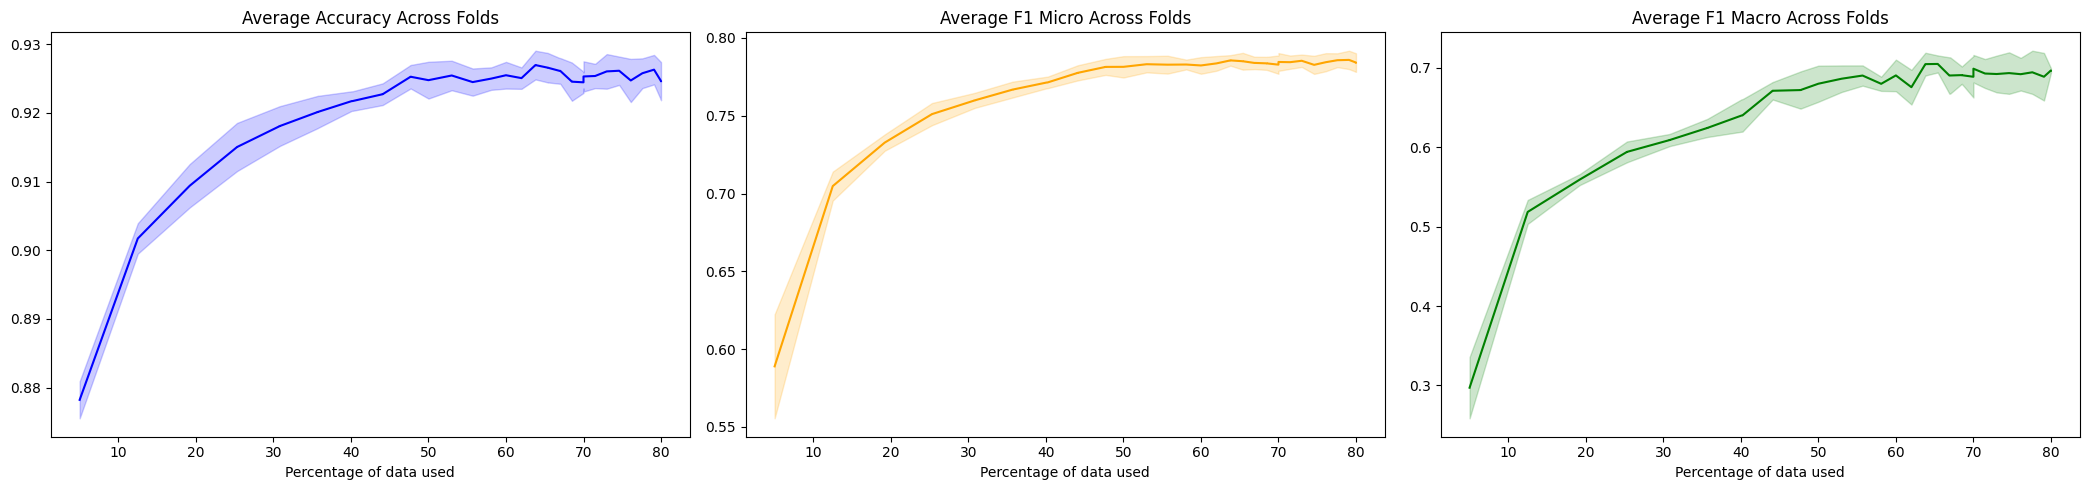

In [20]:
import matplotlib.pyplot as plt
import numpy as np

common_data_points = sorted(list(set(point for fold_points in all_fold_data_used for point in fold_points)))

# Interpolate metrics for each fold to the common data points
avg_accuracies = []
avg_f1_micros = []
avg_f1_macros = []
std_accuracies = []
std_f1_micros = []
std_f1_macros = []

for point in common_data_points:
    point_accuracies = []
    point_f1_micros = []
    point_f1_macros = []
    for i in range(N_SPLITS):
        sorted_indices = np.argsort(all_fold_data_used[i])
        sorted_data = np.array(all_fold_data_used[i])[sorted_indices]
        
        sorted_acc = np.array(all_fold_accuracies[i])[sorted_indices]
        sorted_f1m = np.array(all_fold_f1_micros[i])[sorted_indices]
        sorted_f1ma = np.array(all_fold_f1_macros[i])[sorted_indices]
        
        # Use interpolation to estimate the metric value at the common 'point'
        point_accuracies.append(np.interp(point, sorted_data, sorted_acc))
        point_f1_micros.append(np.interp(point, sorted_data, sorted_f1m))
        point_f1_macros.append(np.interp(point, sorted_data, sorted_f1ma))
    
    avg_accuracies.append(np.mean(point_accuracies))
    avg_f1_micros.append(np.mean(point_f1_micros))
    avg_f1_macros.append(np.mean(point_f1_macros))
    
    std_accuracies.append(np.std(point_accuracies))
    std_f1_micros.append(np.std(point_f1_micros))
    std_f1_macros.append(np.std(point_f1_macros))

# Convert to numpy arrays for easier plotting
avg_accuracies = np.array(avg_accuracies)
avg_f1_micros = np.array(avg_f1_micros)
avg_f1_macros = np.array(avg_f1_macros)
std_accuracies = np.array(std_accuracies)
std_f1_micros = np.array(std_f1_micros)
std_f1_macros = np.array(std_f1_macros)

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
data_used_percent = [round(data / len(X) * 100, 1) for data in common_data_points]

# Plot for Accuracy
axs[0].plot(data_used_percent, avg_accuracies, label="Avg Accuracy", color="blue")
axs[0].fill_between(data_used_percent, avg_accuracies - std_accuracies, avg_accuracies + std_accuracies, color='blue', alpha=0.2)
axs[0].set_xlabel("Percentage of data used")
axs[0].set_title("Average Accuracy Across Folds")

# Plot for F1 Micro
axs[1].plot(data_used_percent, avg_f1_micros, label="Avg F1 Micro", color="orange")
axs[1].fill_between(data_used_percent, avg_f1_micros - std_f1_micros, avg_f1_micros + std_f1_micros, color='orange', alpha=0.2)
axs[1].set_xlabel("Percentage of data used")
axs[1].set_title("Average F1 Micro Across Folds")

# Plot for F1 Macro
axs[2].plot(data_used_percent, avg_f1_macros, label="Avg F1 Macro", color="green")
axs[2].fill_between(data_used_percent, avg_f1_macros - std_f1_macros, avg_f1_macros + std_f1_macros, color='green', alpha=0.2)
axs[2].set_xlabel("Percentage of data used")
axs[2].set_title("Average F1 Macro Across Folds")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

for i in range(N_SPLITS):
    result = pd.DataFrame({
        'Data Used': all_fold_data_used[i],
        'Accuracy': all_fold_accuracies[i],
        'F1 Micro': all_fold_f1_micros[i],
        'F1 Macro': all_fold_f1_macros[i],
    })

    result.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)